# Introduction

In this notebook, firstly a few different base architectures will be explored. After that, some experiments will be performed: data augmentation, pooling layers, batch normalization, regularization to reduce overfitting as well as explore annealing activation functions, initializers, learning rates, and momentum to improve our convergence/training time.

# Setup

In [ ]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00


In [ ]:
#for dataset
import numpy as np 

#for plotting
import matplotlib.pyplot as plt
import math 

#for data preprocessing
from tensorflow.keras.preprocessing import image

#for model layers 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 

#for additional model attributes/tools 

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import time 

#for hypertuning
import keras_tuner as kt 

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#data directory for dataset (must change while running)
data_dir = 'drive/MyDrive/DSA4212/'

# Data Preprocessing


## Import Data

The datasets are in numpy zip files. They are loaded into the directory as numpy. 

In [ ]:
class_names=["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

# load data -- takes a few seconds
data_train = np.load(data_dir+"assignment_1_train.npz")
data_test = np.load(data_dir+"assignment_1_test.npz")

Images re of size 128 by 128 pixels, with 3 RGB layers. The training set contains 9296 images while the testing set contains 3856 images.

In [ ]:
data_train["img"].shape

(9296, 128, 128, 3)

In [ ]:
#extract size of training dataset
full_ds_size = data_train["img"].shape[0]

In [ ]:
data_test["img"].shape

(3856, 128, 128, 3)

## Train-Validation-Test Split

To ease setting up the data pipeline and perform training with tensorflow, the dataset is convered into a tensorflow data. 

In [ ]:
train_all_ds = tf.data.Dataset.from_tensor_slices((data_train["img"], data_train["label"]))
test_ds = tf.data.Dataset.from_tensor_slices((data_test["img"], data_test["label"]))

The training dataset is further split into training and validation sets to allow us to compare across different model's and give a heurisitc/direction on what methods should be incorporated into the final  model. 

The dataset is also first shuffle so that we have a good mix of all the classes in both training and validation sets.

In [ ]:
train_ds = train_all_ds.shuffle(full_ds_size, reshuffle_each_iteration = False, seed = 4212)    #reshuffle is set to false to disallow the train-validation split from having any overlapping data points
val_ds = train_ds.take(full_ds_size//5)     #80-20 split
train_ds = train_ds.skip(full_ds_size//5)

## Pipeline *(includes Augmentation)*

A stochastic gradient descent (mini-batch descent) will be used to reduce computation cost given that our training dataset is fairly large. Hence, the datasets are also put into batches of size 32. Additionally, data caching and prefetching techniques are also used for faster I/O techniques. This improves training time after the first epoch (when entire dataset has been visited once). 


A function is created to replicate our data pipeline conveniently for our experiments with data augmentation and/or image resizing.

In [ ]:
def simple_aug(image):
  """
  Given an image, the function augments it by performing horizontal rotations, slight clockwise/anti-clockwise rotations and slight amounts of zoom
  The augmentation is only performed on 20% of the time at random
  """
  x = np.random.uniform(0,1,1)      #since augmentation increases data size and increases training time, only 20% of the data is augmented
  if x<=0.2:     
    ## not that this method is preferred over the preprocessing augmentation layers due to affect on training time          
    image = tf.image.random_flip_left_right(image)                      #random horizontal flip
    image = tf.keras.preprocessing.image.random_rotation(image, 0.05)   #random rotation (in +- degrees)
    image = tf.keras.preprocessing.image.random_zoom(image, 0.1)        #random zoom of in the range of +-10%
  return image

In [ ]:
#tf.data runtime that tunes the prefetech values and computation parallel calls dynamically
AUTO = tf.data.AUTOTUNE

In [ ]:
def create_train_val_data(train, val, batch_size = 32, aug = False, resize = False, img_size = 128):
  """
  train: training dataset
  val: validation dataset
  batch_size: batch size for dataset, default is 32 
  aug: whether the data is to be augmented or not 
  resize: whether the images in the data need to be resized or not 
  img_size: to be specified if image to be resized to a specified dimension (default 128 by 128, original size) 
  """
  ##preparing training dataset
  train_dat = (train    
              .cache()                  #cache
              .batch(batch_size)        #put into batch
  )
  if resize:  #if need to resize to specified img_size (only square dimensions allowed)
    train_dat = train_dat.map(lambda x, y: (tf.image.resize(x, (img_size, img_size)), y), num_parallel_calls=AUTO)        #
    
  if aug:  #if need to augment, call the augmentation function defined above
    train_dat = train_dat.map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
  train_dat = train_dat.shuffle(9999).prefetch(AUTO)      #shuffle once again, and prefetch


  ##preparing validation dataset
  val_dat = (val
            .cache()            #cache
            .batch(batch_size)  #put into batch
  )
  if resize: #if need to resize to specified img_size (only square dimensions allowed)
    val_dat = val_dat.map(
                  lambda x, y: (tf.image.resize(x, (img_size, img_size)), y),
                  num_parallel_calls=AUTO
              )
    val_dat = val_dat.prefetch(AUTO)     #prefetch data (no shuffling required on validation data)

  
  return train_dat, val_dat
            

We create two sets of dataset, one without augmentation and one with augmentation

In [ ]:
train_batch_ds, val_batch_ds = create_train_val_data(train_ds, val_ds)        #no augmentation 

In [ ]:
train_batch_aug_ds, val_batch_aug_ds = create_train_val_data(train_ds, val_ds, aug = True)      #with augmentation 

#note that there is no augmentation performed on the validation set
#it is merely a label to distinguish the train-validation pair sets for ones with and without augmentation

The test dataset is also cached and prefetched for faster evaluations. It must also be put into batch in order for it to have the same shape. 

In [ ]:
test_ds = test_ds.cache().batch(32).prefetch(AUTO)          #caching, put into batch, and prefetch

Finally, let's do a sanity check on our datasets to ensure they are correct, shuffled and ready for training. 

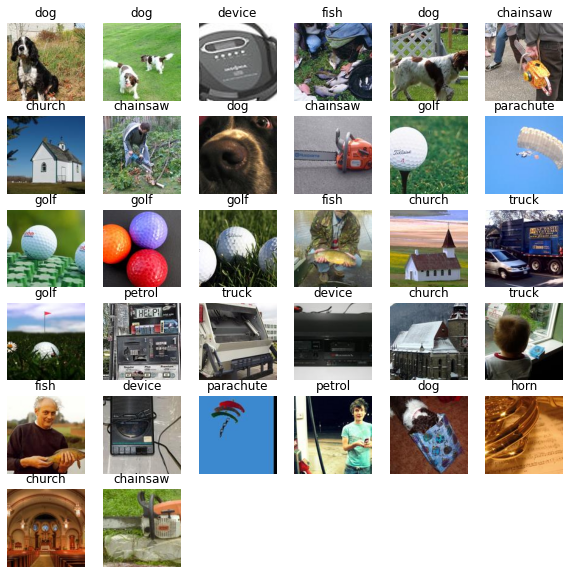

In [ ]:
for images, labels in train_batch_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(32): 
      ax = plt.subplot(6, 6, i+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

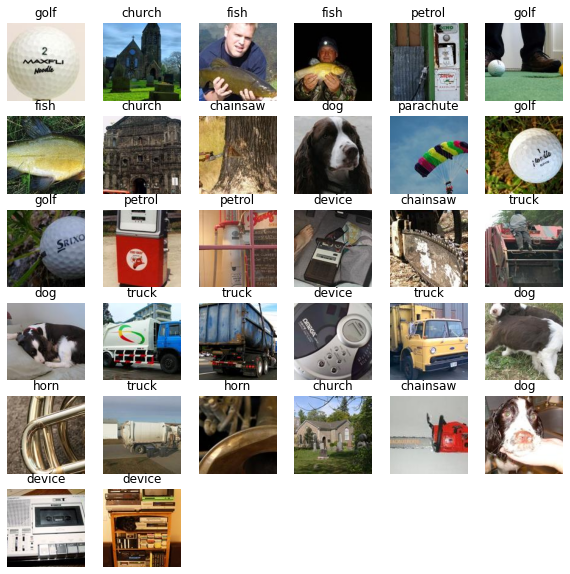

In [ ]:
for images, labels in train_batch_aug_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(32): 
      ax = plt.subplot(6, 6, i+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

# Training

This section will cover the conduct various experiments conducted on the model. 

## Architectures

To establish the benchmark models, a few base architectures and then build upon those. The base models are initialized with the following components: 
<br> 1) Activation/Non-linear: ReLU (except for softmax in the last layer)
<br> 2) ADAM Optimizer (adaptive learning rate) with alpha = 0.001
<br> 3) Loss Function: Sparse Categorical Cross Entropy 
<br> 4) Weight initializer: Glorot Uniform (default)
<br> 5) Epochs: 25
<br> 6) Primary Evaluation Metric: Accuracy 

### VGG-inspired

The first couple architectures are inspired by the VGG architecture. Considering the limit on the training time, the architecture is tweaked to have fewer VGG blocks, and each block containing only 1 convolution layer (instead of 2).

In [ ]:
"""
Model 1: 3 blocks of Convolution-Activation-Max Pooling layers, with 16-32-64 convolution filters 
The FC layers include: a Flatten layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_1 = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')       #10-D vector output for 10 classes (length of the class names list)
])

In [ ]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                      #Optimizer & learning rate       
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),    #from logits = False since we use a softmax layer
                    metrics=['accuracy'])      #evaluation metrics

In [ ]:
start = time.time()                           #start time to start the model training timer

#training 
model_1_fit = model_1.fit(train_batch_ds,     #preprocessed training and validation dataset                               
            validation_data = val_batch_ds, 
            epochs = 25)

end = time.time()                             #end time to end the model training timer

Epoch 1/25
233/233 [==============================] - 17s 13ms/step - loss: 1.7534 - accuracy: 0.3975 - val_loss: 1.4945 - val_accuracy: 0.5137
Epoch 2/25
233/233 [==============================] - 2s 9ms/step - loss: 1.1898 - accuracy: 0.6122 - val_loss: 1.2425 - val_accuracy: 0.5987
Epoch 3/25
233/233 [==============================] - 3s 10ms/step - loss: 0.8960 - accuracy: 0.7070 - val_loss: 1.1695 - val_accuracy: 0.6218
Epoch 4/25
233/233 [==============================] - 3s 11ms/step - loss: 0.6183 - accuracy: 0.8001 - val_loss: 1.2259 - val_accuracy: 0.6272
Epoch 5/25
233/233 [==============================] - 2s 10ms/step - loss: 0.3423 - accuracy: 0.8920 - val_loss: 1.4432 - val_accuracy: 0.6224
Epoch 6/25
233/233 [==============================] - 2s 9ms/step - loss: 0.1675 - accuracy: 0.9493 - val_loss: 1.5881 - val_accuracy: 0.6213
Epoch 7/25
233/233 [==============================] - 2s 10ms/step - loss: 0.0964 - accuracy: 0.9735 - val_loss: 2.0494 - val_accuracy: 0.5987


Note that during the training, the first epoch takes the longest, but the subsequent epochs take fewer time due to data caching and prefetching. As such, we need to keep an extra buffer of 10-15 seconds when considering our time limit of 120s for the subsequent model trials. 

To evaluate our model, we can plot the training and validation accuracy and loss curves throughout the training time. Let us define a function for this so that we can efficiently plot the accuracy and loss curves every time we test out a new model. 

In [ ]:
plt.style.use('ggplot')
def model_performance(fit_history): 
  """ 
  fit_history: history object of the fitted model 
  The function extracts the accuracy, val_accuracy, loss, and val_loss from the history and plots them side-by-side. 
  The function will also output the total time taken, assuming that the 'end' and 'start' variables are globally defined correctly. 
  """
  #extract the training and validation accuracy values
  train_acc = fit_history.history['accuracy']
  val_acc = fit_history.history['val_accuracy']

  #extract the training and validation loss values
  train_loss = fit_history.history['loss']
  val_loss = fit_history.history['val_loss']

  #x axis range (number of training epochs)
  num_epochs = len(fit_history.history['val_accuracy'])
  x_range = range(num_epochs)
  
  #y axis bounds for accuracy and loss plots
  acc_lower_range = math.floor(min(train_acc + val_acc)/0.05) * 0.05
  acc_upper_range = math.ceil((max(train_acc + val_acc)+0.05)/0.05) * 0.05
  loss_lower_range = math.floor(min(train_loss + val_loss)/0.05) * 0.05
  loss_upper_range = math.ceil((max(train_loss + val_loss)+0.05)/0.05) * 0.05

  #Plot the training and accuracy values over the number of epochs 
  plt.figure(figsize=(10, 8))
  plt.subplot(1, 2, 1)
  plt.plot(x_range, train_acc, label='Training Accuracy')
  plt.plot(x_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')                         
  plt.title('Training and Validation Accuracy')
  plt.xticks(np.arange(min(x_range), max(x_range)+1, 5))
  plt.yticks(np.arange(acc_lower_range, acc_upper_range, 0.05))

  #Plot the training and accuracy loss over the number of epochs 
  plt.subplot(1, 2, 2)
  plt.plot(x_range, train_loss, label='Training Loss')
  plt.plot(x_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xticks(np.arange(min(x_range), max(x_range)+1, 5))
  plt.yticks(np.arange(loss_lower_range, loss_upper_range, 0.05))
  
  plt.show()

  ##evaluating the time 
  print("Time taken: ", end-start)      #assuming the global variables are correctly defined during training


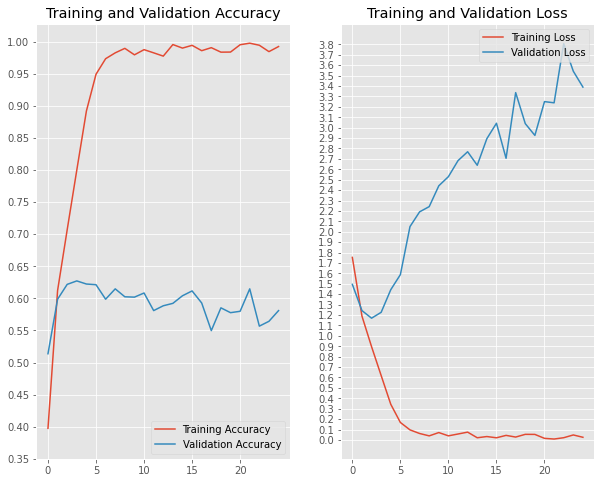

Time taken:  83.18011260032654


In [ ]:
model_performance(model_1_fit)

In [ ]:
"""
Model 2: 3 blocks of Convolution-Activation-Max Pooling layers, with 32-64-128 convolution filters 
The FC layers include: a Flatten layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_2 = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')   
])

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),    #from logits = False since we use a softmax layer
                    metrics=['accuracy'])

In [ ]:
model_2_fit = model_2.fit(train_batch_ds, 
            validation_data = val_batch_ds, 
            epochs = 25)

Epoch 1/25
233/233 [==============================] - 10s 19ms/step - loss: 1.8770 - accuracy: 0.3348 - val_loss: 1.5435 - val_accuracy: 0.4841
Epoch 2/25
233/233 [==============================] - 5s 19ms/step - loss: 1.3382 - accuracy: 0.5602 - val_loss: 1.2772 - val_accuracy: 0.5842
Epoch 3/25
233/233 [==============================] - 4s 17ms/step - loss: 1.0219 - accuracy: 0.6723 - val_loss: 1.2697 - val_accuracy: 0.6062
Epoch 4/25
233/233 [==============================] - 4s 18ms/step - loss: 0.7642 - accuracy: 0.7526 - val_loss: 1.2040 - val_accuracy: 0.6132
Epoch 5/25
233/233 [==============================] - 4s 19ms/step - loss: 0.4851 - accuracy: 0.8443 - val_loss: 1.2989 - val_accuracy: 0.6283
Epoch 6/25
233/233 [==============================] - 4s 18ms/step - loss: 0.2560 - accuracy: 0.9204 - val_loss: 1.6667 - val_accuracy: 0.6003
Epoch 7/25
233/233 [==============================] - 4s 17ms/step - loss: 0.1401 - accuracy: 0.9558 - val_loss: 1.8762 - val_accuracy: 0.627

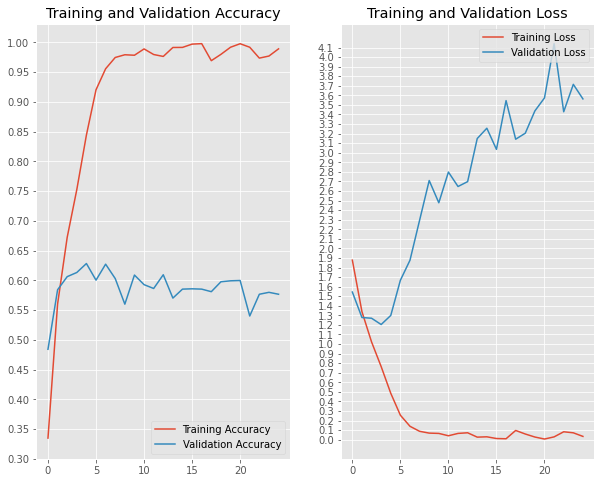

Time taken:  83.18011260032654


In [ ]:
model_performance(model_2_fit)

From the model performance evaluation, it is evident that both models are heavily overfitting. Ways to mitigate this (and hence improve the validation accuracy) will be addressed in the experimentation methods. 

In the meantime, comparing the two models does not show any significant performance difference. 

### LeNet 5

Next, the LeNet 5 architecture is a small and simple architecture that performs fairly well. 

In [ ]:
"""
Model 3: LeNet 5: 3 blocks of Convolution-Activation-Average Pooling layers
The FC layers include: a Flatten layer to flatten all the outputs, followed by a dense layer of 84 units and a softmax layer 
"""
model_3 = keras.models.Sequential([
    keras.layers.Rescaling(1./255),
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='relu', padding='same'), 
    keras.layers.AveragePooling2D(), 
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'),    #no padding 2nd layer onwards, as seen in the original architecture
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'), 
    keras.layers.Flatten(),  
    keras.layers.Dense(84, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    metrics=['accuracy'])

In [ ]:
model_3_fit = model_3.fit(train_batch_ds, 
                          validation_data = val_batch_ds,
                          epochs = 25)

Epoch 1/25
233/233 [==============================] - 5s 14ms/step - loss: 1.8011 - accuracy: 0.3739 - val_loss: 1.5662 - val_accuracy: 0.4771
Epoch 2/25
233/233 [==============================] - 3s 11ms/step - loss: 1.3339 - accuracy: 0.5650 - val_loss: 1.3895 - val_accuracy: 0.5530
Epoch 3/25
233/233 [==============================] - 3s 11ms/step - loss: 1.0679 - accuracy: 0.6497 - val_loss: 1.2750 - val_accuracy: 0.5820
Epoch 4/25
233/233 [==============================] - 3s 11ms/step - loss: 0.7547 - accuracy: 0.7546 - val_loss: 1.4665 - val_accuracy: 0.5498
Epoch 5/25
233/233 [==============================] - 3s 12ms/step - loss: 0.4686 - accuracy: 0.8540 - val_loss: 1.6273 - val_accuracy: 0.5632
Epoch 6/25
233/233 [==============================] - 3s 11ms/step - loss: 0.2193 - accuracy: 0.9336 - val_loss: 2.0000 - val_accuracy: 0.5492
Epoch 7/25
233/233 [==============================] - 3s 11ms/step - loss: 0.1004 - accuracy: 0.9697 - val_loss: 2.3314 - val_accuracy: 0.5691

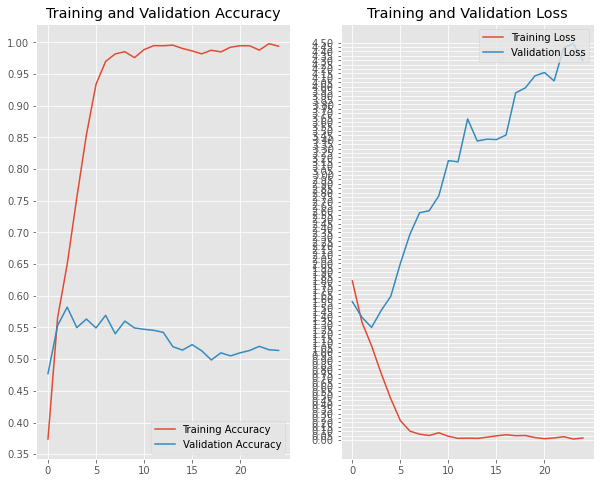

Time taken:  111.08630275726318


In [ ]:
model_performance(model_3_fit)

The LeNet 5 Model is also running into overfitting currently. However, the validation accuracy seems to be generally decreasing at a greater rate than the validation accuracy from the VGG-inspired models. 

### Conclusion

Overall, the VGG-inspired model looks more stable and has a better chance of performing with higher accuracy. Hence, model 1 and model 2 archtiectures are selected to continue for the next steps. From here on, these architecture will be refered to as as VGG-A (Model 1: 16-32-64 filters) and VGG-B (Model 2: 32-64-128 filters). Although VGG-B seems to take more time (due to more convolution filters), we won't rule it out since it may still be able to perform as good as/better than VGG-A after we apply tecniques to mitigate overfitting/improve accuracy

## Pooling Layer

In [ ]:
tf.keras.backend.clear_session()      #this command will be repeatedly use to remove avoid unnecessary cluter from layers/models not being used

The first strategy explored to mitigate overfitting is to replace the Flatten layer in the FC layers by Pooling layers to reduce the number of parameters. 

Global max and global average poolings are both explored. While global max pooling allows to focus on higher-level features/intensities, global average pooling allows to smooth out the image (but may not capture some of the sharper features) 

Given that most of the images in the dataset do not really have objects placed in dark backgrounds, it is hypothesized that the global average pooling layer 
may outperform global max pooling layer. 

### Global Max Pooling

Note that the global max pooling will be experimented on the 2 architectures concluded in the previous section: VGG-A and VGG-B

In [ ]:
"""
Model VGG-A: 3 blocks of Convolution-Activation-Max Pooling layers, with 16-32-64 convolution filters 
The FC layers include: a Global Max Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_a_max = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),    
    layers.GlobalMaxPooling2D(),      #layer replaced with global Max pooling
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_a_max.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    metrics=['accuracy'])

In [ ]:
start = time.time()
model_a_max_fit = model_a_max.fit(train_batch_ds, 
                                  validation_data = val_batch_ds, 
                                  epochs = 25)
end = time.time()

Epoch 1/25
233/233 [==============================] - 5s 13ms/step - loss: 2.0517 - accuracy: 0.2696 - val_loss: 1.7622 - val_accuracy: 0.4002
Epoch 2/25
233/233 [==============================] - 3s 11ms/step - loss: 1.6003 - accuracy: 0.4548 - val_loss: 1.5239 - val_accuracy: 0.4917
Epoch 3/25
233/233 [==============================] - 3s 11ms/step - loss: 1.4259 - accuracy: 0.5233 - val_loss: 1.4114 - val_accuracy: 0.5331
Epoch 4/25
233/233 [==============================] - 4s 15ms/step - loss: 1.3019 - accuracy: 0.5682 - val_loss: 1.3844 - val_accuracy: 0.5503
Epoch 5/25
233/233 [==============================] - 6s 23ms/step - loss: 1.2137 - accuracy: 0.5994 - val_loss: 1.2726 - val_accuracy: 0.5729
Epoch 6/25
233/233 [==============================] - 4s 17ms/step - loss: 1.1462 - accuracy: 0.6205 - val_loss: 1.2053 - val_accuracy: 0.6073
Epoch 7/25
233/233 [==============================] - 6s 23ms/step - loss: 1.0598 - accuracy: 0.6543 - val_loss: 1.2824 - val_accuracy: 0.5944

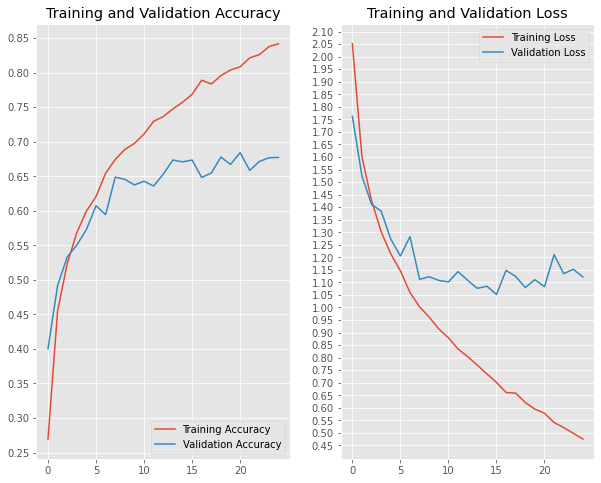

Time taken:  99.262362241745


In [ ]:
model_performance(model_a_max_fit)

In [ ]:
"""
Model VGG-B: 3 blocks of Convolution-Activation-Max Pooling layers, with 16-32-64 convolution filters 
The FC layers include: a Global Max Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_b_max = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalMaxPooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_b_max.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    metrics=['accuracy'])

In [ ]:
start = time.time()
model_b_max_fit = model_b_max.fit(train_batch_ds, 
                                  validation_data = val_batch_ds, 
                                  epochs = 25)
end = time.time()

Epoch 1/25
233/233 [==============================] - 9s 24ms/step - loss: 2.0281 - accuracy: 0.2810 - val_loss: 1.8877 - val_accuracy: 0.3448
Epoch 2/25
233/233 [==============================] - 6s 22ms/step - loss: 1.4379 - accuracy: 0.5264 - val_loss: 1.2846 - val_accuracy: 0.5777
Epoch 3/25
233/233 [==============================] - 4s 16ms/step - loss: 1.1683 - accuracy: 0.6146 - val_loss: 1.1680 - val_accuracy: 0.6192
Epoch 4/25
233/233 [==============================] - 6s 23ms/step - loss: 1.0228 - accuracy: 0.6694 - val_loss: 1.1205 - val_accuracy: 0.6347
Epoch 5/25
233/233 [==============================] - 6s 22ms/step - loss: 0.9171 - accuracy: 0.7040 - val_loss: 0.9786 - val_accuracy: 0.6853
Epoch 6/25
233/233 [==============================] - 6s 24ms/step - loss: 0.8433 - accuracy: 0.7291 - val_loss: 1.0160 - val_accuracy: 0.6659
Epoch 7/25
233/233 [==============================] - 5s 20ms/step - loss: 0.7800 - accuracy: 0.7443 - val_loss: 0.9913 - val_accuracy: 0.6880

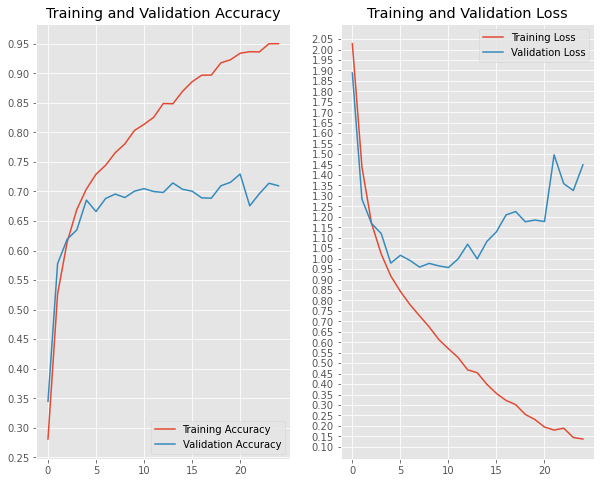

Time taken:  131.38448882102966


In [ ]:
model_performance(model_b_max_fit)

Although there is still some overfitting seen in the validation performance, it definitely has higher accuracy in comparison to using just a Flatten layer. 

To be addressed later: 
Additionally, even though VGG-B achieves a higher accuracy, but VGG-A takes lesser time as expected given that it has fewer convolution filters. These will be adjusted and experimented later by adjusting the number of epochs and learning rate. 

### Global Average Pooling

In [ ]:
"""
Model VGG-A: 3 blocks of Convolution-Activation-Max Pooling layers, with 16-32-64 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_a_avg = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),      #replaced by global average pooling
    layers.Dense(128, activation='relu'),   
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_a_avg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    metrics=['accuracy'])

In [ ]:
start = time.time()
model_a_avg_fit = model_a_avg.fit(train_batch_ds, 
                                  validation_data = val_batch_ds, 
                                  epochs = 25)
end = time.time()

Epoch 1/25
233/233 [==============================] - 4s 12ms/step - loss: 2.1022 - accuracy: 0.2280 - val_loss: 1.9693 - val_accuracy: 0.2921
Epoch 2/25
233/233 [==============================] - 3s 10ms/step - loss: 1.8645 - accuracy: 0.3362 - val_loss: 1.8881 - val_accuracy: 0.3432
Epoch 3/25
233/233 [==============================] - 2s 9ms/step - loss: 1.7573 - accuracy: 0.3886 - val_loss: 1.7301 - val_accuracy: 0.4115
Epoch 4/25
233/233 [==============================] - 2s 9ms/step - loss: 1.6527 - accuracy: 0.4332 - val_loss: 1.6592 - val_accuracy: 0.4174
Epoch 5/25
233/233 [==============================] - 3s 11ms/step - loss: 1.6049 - accuracy: 0.4435 - val_loss: 1.6189 - val_accuracy: 0.4513
Epoch 6/25
233/233 [==============================] - 3s 11ms/step - loss: 1.5214 - accuracy: 0.4767 - val_loss: 1.5495 - val_accuracy: 0.4621
Epoch 7/25
233/233 [==============================] - 2s 9ms/step - loss: 1.4593 - accuracy: 0.5085 - val_loss: 1.5685 - val_accuracy: 0.4777
Ep

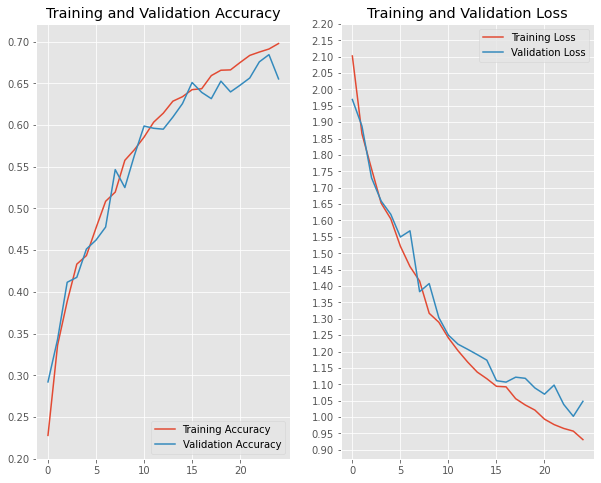

Time taken:  77.45399069786072


In [ ]:
model_performance(model_a_avg_fit)

In [ ]:
"""
Model VGG-B: 3 blocks of Convolution-Activation-Max Pooling layers, with 16-32-64 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_b_avg = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),    #replaced by global average pooling
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_b_avg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    metrics=['accuracy'])

In [ ]:
start = time.time()
model_b_avg_fit = model_b_avg.fit(train_batch_ds, 
                                  validation_data = val_batch_ds, 
                                  epochs = 25)
end = time.time()

Epoch 1/25
233/233 [==============================] - 6s 20ms/step - loss: 2.1029 - accuracy: 0.2333 - val_loss: 1.9169 - val_accuracy: 0.3297
Epoch 2/25
233/233 [==============================] - 4s 16ms/step - loss: 1.7937 - accuracy: 0.3796 - val_loss: 1.6411 - val_accuracy: 0.4470
Epoch 3/25
233/233 [==============================] - 4s 16ms/step - loss: 1.5995 - accuracy: 0.4522 - val_loss: 1.5163 - val_accuracy: 0.4911
Epoch 4/25
233/233 [==============================] - 5s 19ms/step - loss: 1.4681 - accuracy: 0.5042 - val_loss: 1.4624 - val_accuracy: 0.5056
Epoch 5/25
233/233 [==============================] - 4s 17ms/step - loss: 1.3517 - accuracy: 0.5524 - val_loss: 1.3578 - val_accuracy: 0.5438
Epoch 6/25
233/233 [==============================] - 4s 17ms/step - loss: 1.2750 - accuracy: 0.5759 - val_loss: 1.4715 - val_accuracy: 0.5056
Epoch 7/25
233/233 [==============================] - 4s 19ms/step - loss: 1.2178 - accuracy: 0.5989 - val_loss: 1.2107 - val_accuracy: 0.5955

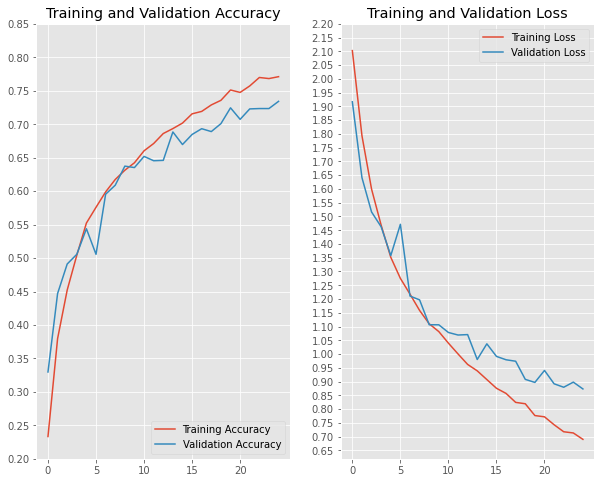

Time taken:  111.83293437957764


In [ ]:
model_performance(model_b_avg_fit)

Evidently, global average pooling works significantly better in reducing the overfitting in comparison to global max pooling. The performance on each of the models, however, are comparable.

### Conclusion

1) Pooling Layer: Global Average Pooling will be incorporated from here onwards.
<br> 2) Architecture: Both architectures perform roughly the same. Although VGG-B has a higher accuracy, it also has a higher training time for the same 25 epochs. In fact, increasing the number of epochs for VGG-A can also allow it to match up the higher accuracy produced by VGG-B(as shown below). Hence, neither of the architectures will be ruled out. 

In [ ]:
"""
Model VGG-A: 3 blocks of Convolution-Max Pooling layers, with 16-32-64 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_a_avg = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_a_avg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    metrics=['accuracy'])

In [ ]:
start = time.time()
model_a_avg_fit = model_a_avg.fit(train_batch_ds, 
                                  validation_data = val_batch_ds, 
                                  epochs = 40)      #training for more epochs 
end = time.time()

Epoch 1/40
233/233 [==============================] - 4s 10ms/step - loss: 2.1377 - accuracy: 0.2139 - val_loss: 2.0030 - val_accuracy: 0.3179
Epoch 2/40
233/233 [==============================] - 2s 9ms/step - loss: 1.8706 - accuracy: 0.3437 - val_loss: 1.7985 - val_accuracy: 0.3653
Epoch 3/40
233/233 [==============================] - 2s 9ms/step - loss: 1.7333 - accuracy: 0.3987 - val_loss: 1.6928 - val_accuracy: 0.4142
Epoch 4/40
233/233 [==============================] - 2s 9ms/step - loss: 1.6239 - accuracy: 0.4381 - val_loss: 1.6043 - val_accuracy: 0.4400
Epoch 5/40
233/233 [==============================] - 3s 11ms/step - loss: 1.5269 - accuracy: 0.4697 - val_loss: 1.5176 - val_accuracy: 0.4739
Epoch 6/40
233/233 [==============================] - 2s 10ms/step - loss: 1.4778 - accuracy: 0.4976 - val_loss: 1.4664 - val_accuracy: 0.5040
Epoch 7/40
233/233 [==============================] - 2s 9ms/step - loss: 1.4025 - accuracy: 0.5241 - val_loss: 1.3696 - val_accuracy: 0.5524
Epo

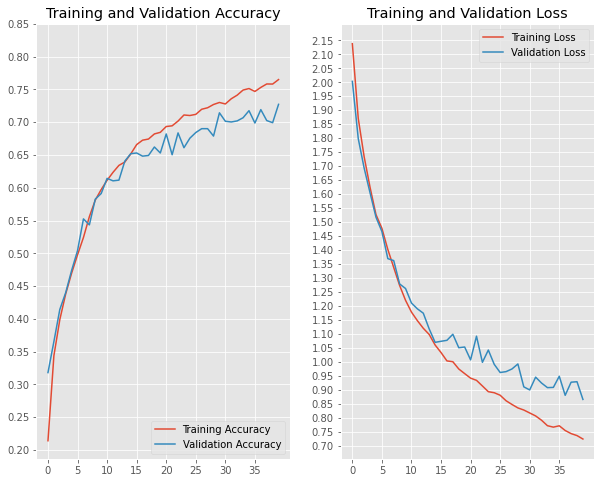

Time taken:  104.60864782333374


In [ ]:
model_performance(model_a_avg_fit)

Upon increasing the training time (via number of epochs), the performance of VGG-A is almost the same as the performance of VGG-B. 

This can be better visualized by plotting the training/validation curves of both models side by side. The following function is defined to help in plotting curves of two models repeatedly in future experiments. 

In [ ]:
plt.style.use('ggplot')
def model_performance_two(fit_history1, model1_name, fit_history2, model2_name): 
  """ 
  fit_history1: history object of the first/based fitted model 
  model1_name: first model's label to be used on the plot 
  fit_history1: history object of the second fitted model 
  model2_name: second model's label to be used on the plot 
  The function extracts the accuracy, val_accuracy, loss, and val_loss from both models and plots them side-by-side. 
  The function will also output the total time taken, assuming that the 'end' and 'start' variables are globally defined correctly. 
  """

  ## History 1 ##
  #extract the training and validation accuracy values
  train_acc1 = fit_history1.history['accuracy']
  val_acc1 = fit_history1.history['val_accuracy']

  #extract the training and validation loss values
  train_loss1 = fit_history1.history['loss']
  val_loss1 = fit_history1.history['val_loss']

  num_epochs1 = len(fit_history1.history['val_accuracy'])
  x_range1 = range(num_epochs1)
  
  acc_lower_range1 = math.floor(min(train_acc1 + val_acc1)/0.05) * 0.05
  acc_upper_range1 = math.ceil((max(train_acc1 + val_acc1)+0.05)/0.05) * 0.05
  loss_lower_range1 = math.floor(min(train_loss1 + val_loss1)/0.05) * 0.05
  loss_upper_range1 = math.ceil((max(train_loss1 + val_loss1)+0.05)/0.05) * 0.05


  ## History 2 ##
  #extract the training and validation accuracy values
  train_acc2 = fit_history2.history['accuracy']
  val_acc2 = fit_history2.history['val_accuracy']

  #extract the training and validation loss values
  train_loss2 = fit_history2.history['loss']
  val_loss2 = fit_history2.history['val_loss']

  num_epochs2 = len(fit_history2.history['val_accuracy'])
  x_range2 = range(num_epochs2)
  
  acc_lower_range2 = math.floor(min(train_acc2 + val_acc2)/0.05) * 0.05
  acc_upper_range2 = math.ceil((max(train_acc2 + val_acc2)+0.05)/0.05) * 0.05
  loss_lower_range2 = math.floor(min(train_loss2 + val_loss2)/0.05) * 0.05
  loss_upper_range2 = math.ceil((max(train_loss2 + val_loss2)+0.05)/0.05) * 0.05

  ## Plot History 1 ##
  #Plot the training and accuracy values over the number of epochs 
  plt.figure(figsize=(23, 8))
  plt.subplot(1, 4, 1)
  plt.plot(x_range1, train_acc1, label='Training Accuracy')
  plt.plot(x_range1, val_acc1, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training & Validation Accuracy '+ model1_name)
  plt.xticks(np.arange(min(x_range1), max(x_range1)+1, 5))
  plt.yticks(np.arange(acc_lower_range1, acc_upper_range1, 0.05))

  #Plot the training and accuracy loss over the number of epochs 
  plt.subplot(1, 4, 3)
  plt.plot(x_range1, train_loss1, label='Training Loss')
  plt.plot(x_range1, val_loss1, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss ' + model1_name)
  plt.xticks(np.arange(min(x_range1), max(x_range1)+1, 5))
  plt.yticks(np.arange(loss_lower_range2, loss_upper_range2, 0.05))
  
  ## Plot History 2 ##
  #Plot the training and accuracy values over the number of epochs 
  plt.subplot(1, 4, 2)
  plt.plot(x_range2, train_acc2, label='Training Accuracy')
  plt.plot(x_range2, val_acc2, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training & Validation Accuracy '+ model2_name)
  plt.xticks(np.arange(min(x_range2), max(x_range2)+1, 5))
  plt.yticks(np.arange(acc_lower_range1, acc_upper_range1, 0.05))

  #Plot the training and accuracy loss over the number of epochs 
  plt.subplot(1, 4, 4)
  plt.plot(x_range2, train_loss2, label='Training Loss')
  plt.plot(x_range2, val_loss2, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss ' + model2_name)
  plt.xticks(np.arange(min(x_range2), max(x_range2)+1, 5))
  plt.yticks(np.arange(loss_lower_range2, loss_upper_range2, 0.05))

  plt.show()

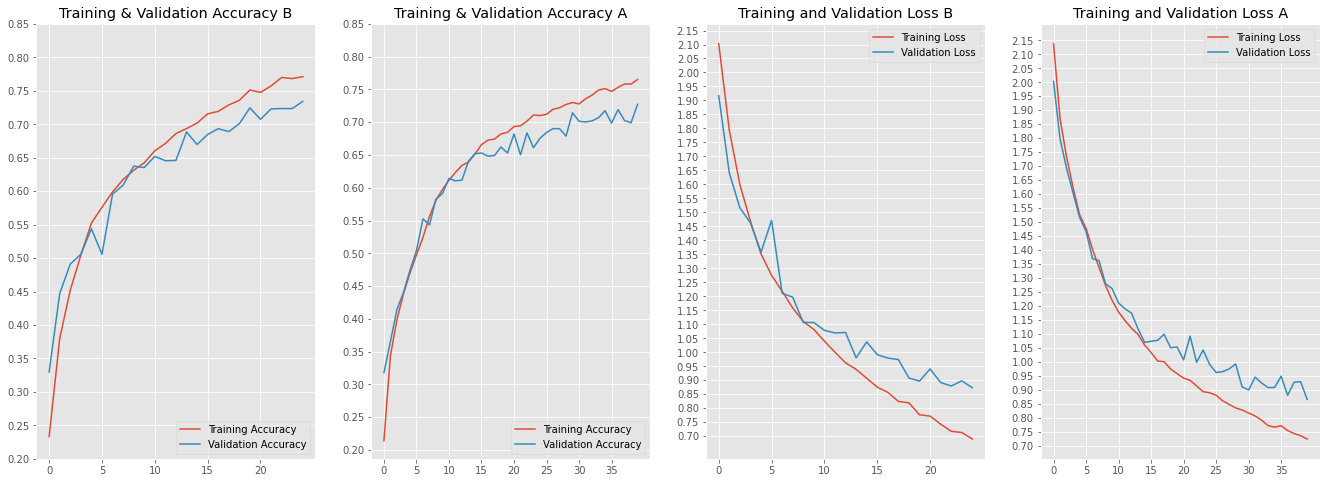

In [ ]:
model_performance_two(model_b_avg_fit, 'B', model_a_avg_fit, 'A')

In terms of accuracy and loss, both models have about the same performance. However, it seems that the trajectory of model 2 (which is the model A architecture trained for more epochs) seems to be fluctuating more. Nonetheless, it seems to similar to rule either one out. 

## Data Augmentation

In [ ]:
tf.keras.backend.clear_session()

Another popular method used to mitigate overfitting is data augmentation.This not only increases the size and variety of the dataset but also acts as a regularizer to reduce overfitting. Note that the two models A & B will now be incorporating the usage of a global average pooling layer.  

The augmentation of the images has been performed in the preprocessing stage, where only 20% of the images are randomly augmented to avoid having too large of a dataset that will slow down our training time. 

In [ ]:
"""
Model VGG-A: 3 blocks of Convolution-Activation-Max Pooling layers, with 16-32-64 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_a_aug = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_a_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    metrics=['accuracy'])

Since we have seen model A can still achieve a higher performance with more training time, we will be using 35 epochs to train model A.

In [ ]:
start = time.time()
model_a_aug_fit = model_a_aug.fit(train_batch_aug_ds,                 #augmented training dataset 
                                  validation_data = val_batch_aug_ds, #no augmentation in validation set, merely a label to distinguish the train-valid pair 
                                  epochs = 40)
end = time.time()

Epoch 1/40
233/233 [==============================] - 4s 10ms/step - loss: 2.1042 - accuracy: 0.2340 - val_loss: 1.9831 - val_accuracy: 0.3185
Epoch 2/40
233/233 [==============================] - 2s 9ms/step - loss: 1.8308 - accuracy: 0.3558 - val_loss: 1.7704 - val_accuracy: 0.3954
Epoch 3/40
233/233 [==============================] - 2s 10ms/step - loss: 1.7105 - accuracy: 0.4010 - val_loss: 1.6593 - val_accuracy: 0.4476
Epoch 4/40
233/233 [==============================] - 3s 10ms/step - loss: 1.6210 - accuracy: 0.4416 - val_loss: 1.5849 - val_accuracy: 0.4728
Epoch 5/40
233/233 [==============================] - 2s 10ms/step - loss: 1.5528 - accuracy: 0.4671 - val_loss: 1.5594 - val_accuracy: 0.4664
Epoch 6/40
233/233 [==============================] - 2s 9ms/step - loss: 1.5043 - accuracy: 0.4901 - val_loss: 1.5778 - val_accuracy: 0.4632
Epoch 7/40
233/233 [==============================] - 2s 9ms/step - loss: 1.4619 - accuracy: 0.4983 - val_loss: 1.4842 - val_accuracy: 0.5056
Ep

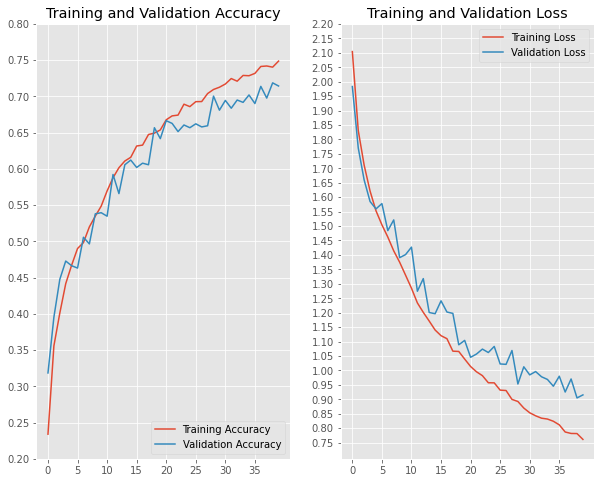

Time taken:  100.84105801582336


In [ ]:
model_performance(model_a_aug_fit)

The data augmention model is compared to the best model found so far: the model using global average pooling. 

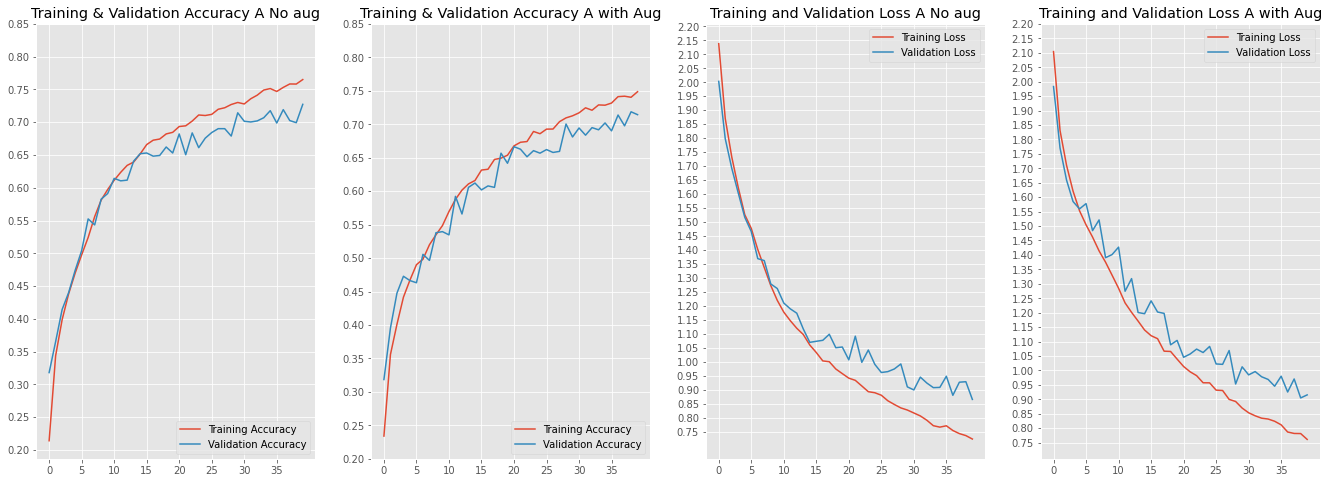

In [ ]:
model_performance_two(model_a_avg_fit, 'A No aug',  model_a_aug_fit, 'A with Aug')

As seen above, augmentation not only slightly reduces the accuracy (and increases the loss), but also makes the validation curves fluctuate a lot more. 

In [ ]:
"""
Model B: 3 blocks of Convolution-Activation-Max Pooling layers, with 32-64-128 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_b_aug = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_b_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    metrics=['accuracy'])

In [ ]:
start = time.time()
model_b_aug_fit = model_b_aug.fit(train_batch_aug_ds, 
                                  validation_data = val_batch_aug_ds, 
                                  epochs = 25)
end = time.time()

Epoch 1/25
233/233 [==============================] - 6s 17ms/step - loss: 2.0938 - accuracy: 0.2342 - val_loss: 1.9341 - val_accuracy: 0.2991
Epoch 2/25
233/233 [==============================] - 4s 17ms/step - loss: 1.7989 - accuracy: 0.3659 - val_loss: 1.7483 - val_accuracy: 0.3755
Epoch 3/25
233/233 [==============================] - 4s 16ms/step - loss: 1.6612 - accuracy: 0.4289 - val_loss: 1.7576 - val_accuracy: 0.4008
Epoch 4/25
233/233 [==============================] - 4s 16ms/step - loss: 1.5487 - accuracy: 0.4687 - val_loss: 1.4930 - val_accuracy: 0.4911
Epoch 5/25
233/233 [==============================] - 4s 17ms/step - loss: 1.4171 - accuracy: 0.5200 - val_loss: 1.4057 - val_accuracy: 0.5239
Epoch 6/25
233/233 [==============================] - 4s 16ms/step - loss: 1.3088 - accuracy: 0.5646 - val_loss: 1.3389 - val_accuracy: 0.5568
Epoch 7/25
233/233 [==============================] - 4s 16ms/step - loss: 1.2447 - accuracy: 0.5824 - val_loss: 1.2214 - val_accuracy: 0.6068

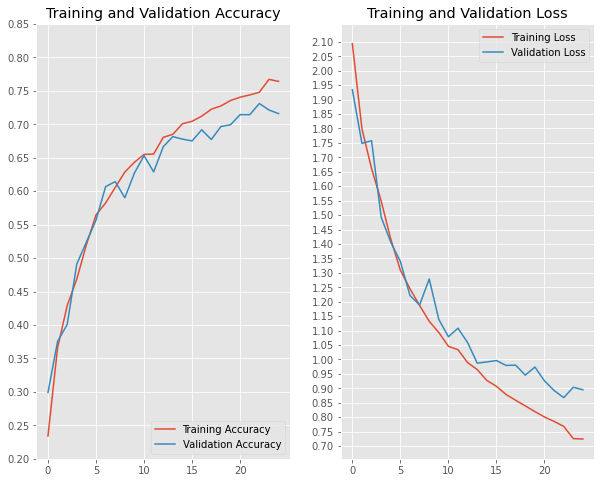

Time taken:  108.59544706344604


In [ ]:
model_performance(model_b_aug_fit)

The data augmention model is compared to the best model found so far: the model using global average pooling. 

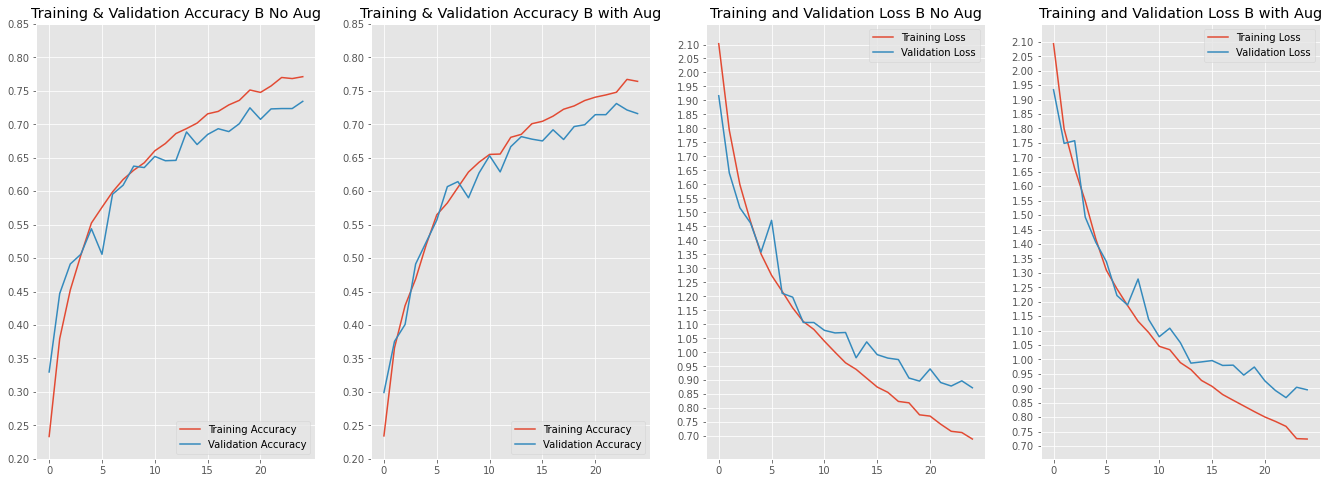

In [ ]:
model_performance_two(model_b_avg_fit, 'B No Aug', model_b_aug_fit, 'B with Aug')

As seen above, augmentation not only slightly reduces the accuracy (and increases the loss), but also makes the validation curves fluctuate a lot more. 

### Conclusion

Data augmentation will not be incorporated in the models since it either performs around the same or worse in terms of accuracy/loss. It also 
<br> 1) It keeps the model performance same or worse (across multiple training runs) in terms of accuracy/loss. 
<br> 2) Creates more fluctuation in the validation curve, resulting in a more unstable model. 
<br> 3) Increases the training time. Hence, the trade-off does not seem feasible and the model is better off without any forms of data augmentation in the training dataset. 

## Regularization 

Regularization is another techinque used to penalize large weights in the network by adding the L2-Norm of the model weights to the loss function. This makes the model less flexible and hence less sensitive to overfitting. 

### L2 Norm

In [ ]:
tf.keras.backend.clear_session()

Note that once again the two best models found so far (VGG-A and VGG-B with global average pooling) are used as the benchmark to compare with the regularized models. 

In [ ]:
"""
Model VGG-A: 3 blocks of Convolution-Activation-Max Pooling layers, with 16-32-64 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_a_reg = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),     #regularization added in the convolution layers, with a factor of 0.0001
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_a_reg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
start = time.time()
model_a_reg_fit = model_a_reg.fit(train_batch_ds, 
                              validation_data = val_batch_ds, 
                              epochs = 40)
end = time.time()

Epoch 1/40
233/233 [==============================] - 4s 10ms/step - loss: 2.1663 - accuracy: 0.2042 - val_loss: 2.0460 - val_accuracy: 0.2760
Epoch 2/40
233/233 [==============================] - 2s 10ms/step - loss: 1.9677 - accuracy: 0.3016 - val_loss: 1.9708 - val_accuracy: 0.3029
Epoch 3/40
233/233 [==============================] - 3s 11ms/step - loss: 1.8181 - accuracy: 0.3586 - val_loss: 1.8668 - val_accuracy: 0.3190
Epoch 4/40
233/233 [==============================] - 2s 10ms/step - loss: 1.6947 - accuracy: 0.4187 - val_loss: 1.7753 - val_accuracy: 0.3626
Epoch 5/40
233/233 [==============================] - 2s 10ms/step - loss: 1.6178 - accuracy: 0.4431 - val_loss: 1.6415 - val_accuracy: 0.4529
Epoch 6/40
233/233 [==============================] - 2s 9ms/step - loss: 1.5607 - accuracy: 0.4706 - val_loss: 1.5602 - val_accuracy: 0.4675
Epoch 7/40
233/233 [==============================] - 2s 10ms/step - loss: 1.5056 - accuracy: 0.4956 - val_loss: 1.5364 - val_accuracy: 0.4798


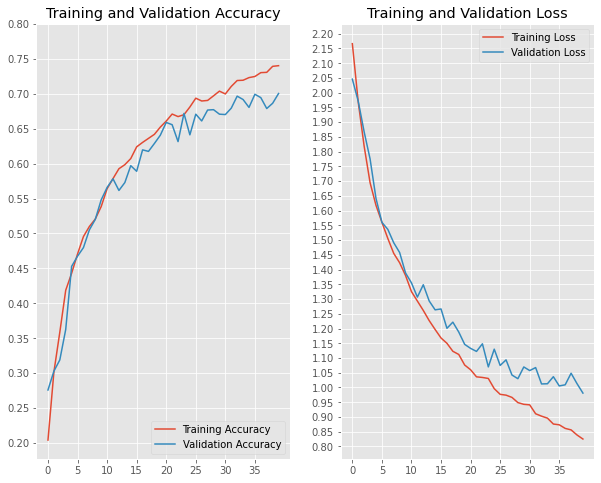

Time taken:  105.81210947036743


In [ ]:
model_performance(model_a_reg_fit)

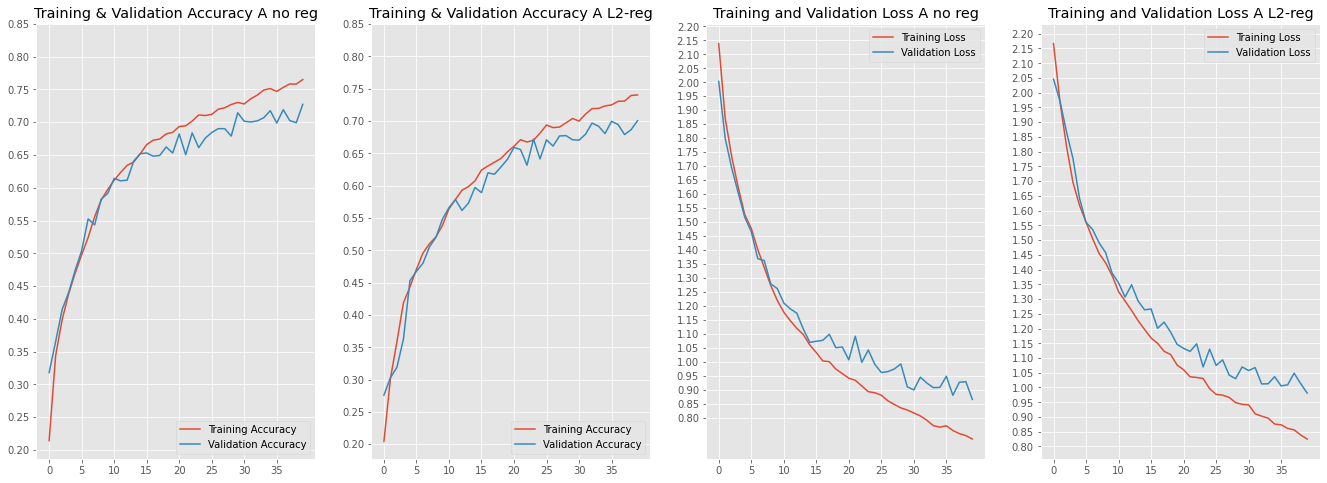

In [ ]:
model_performance_two(model_a_avg_fit, 'A no reg', model_a_reg_fit, 'A L2-reg')

In [ ]:
"""
Model VGG-B: 3 blocks of Convolution-Max Pooling layers, with 32-64-128 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_b_reg = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_b_reg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
start = time.time()
model_b_reg_fit = model_b_reg.fit(train_batch_ds, 
                              validation_data = val_batch_ds, 
                              epochs = 25)
end = time.time()

Epoch 1/25
233/233 [==============================] - 8s 26ms/step - loss: 2.0629 - accuracy: 0.2489 - val_loss: 1.9312 - val_accuracy: 0.3185
Epoch 2/25
233/233 [==============================] - 6s 23ms/step - loss: 1.7610 - accuracy: 0.3863 - val_loss: 1.7694 - val_accuracy: 0.3921
Epoch 3/25
233/233 [==============================] - 6s 23ms/step - loss: 1.6291 - accuracy: 0.4444 - val_loss: 1.5748 - val_accuracy: 0.4637
Epoch 4/25
233/233 [==============================] - 6s 24ms/step - loss: 1.5051 - accuracy: 0.4927 - val_loss: 1.5535 - val_accuracy: 0.4621
Epoch 5/25
233/233 [==============================] - 5s 21ms/step - loss: 1.4202 - accuracy: 0.5282 - val_loss: 1.4164 - val_accuracy: 0.5347
Epoch 6/25
233/233 [==============================] - 5s 20ms/step - loss: 1.3464 - accuracy: 0.5571 - val_loss: 1.3170 - val_accuracy: 0.5713
Epoch 7/25
233/233 [==============================] - 6s 24ms/step - loss: 1.2963 - accuracy: 0.5783 - val_loss: 1.3987 - val_accuracy: 0.5363

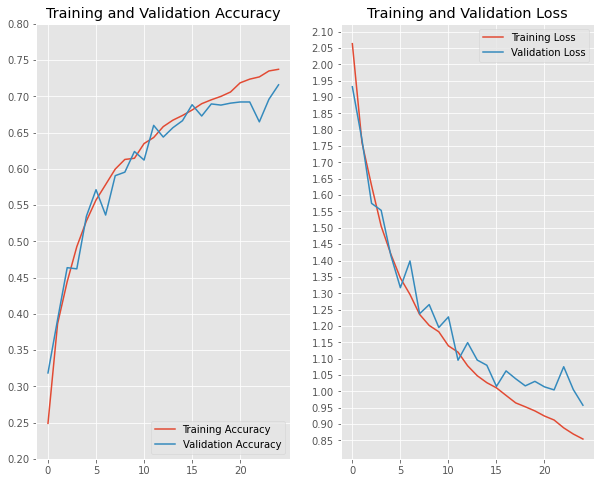

Time taken:  154.10468673706055


In [ ]:
model_performance(model_b_reg_fit)

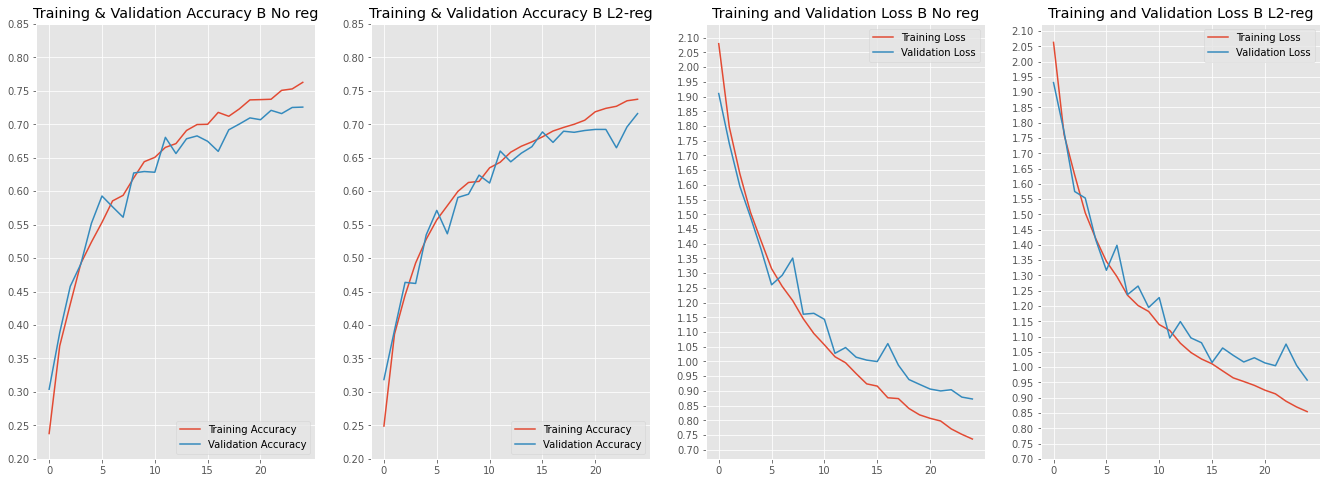

In [ ]:
model_performance_two(model_b_avg_fit, 'B No reg', model_b_reg_fit, 'B L2-reg')

### Conclusion

As seen above, regularization decreases the model performance for both the VGG-A and VGG-B architectures. Fine tuning the regularization parameter may not also be beneficial, since it will also incur more time, especially as seen by model B above. Hence, regularization will not be used. 

## Batch Normalization

Asides using a rescaling layer to normalize the inputs to 0 to 1, batch normalization layers can also be used in between the convolution and activation layers to standardized the convolution layer outputs. 

Once again, the 2 best models so far (VGG-A and VGG-B with global average pooling layers) are tested out with batch normalization layers below.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
"""
Model VGG-A: 3 blocks of Convolution-Batch Normalization-Activation-Max Pooling layers, with 16-32-64 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_a_norm = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(16, 3, padding='same'),    #no activation sepcified here (default is None)
    layers.BatchNormalization(),             #batch normalization layer after the convolution 
    layers.Activation(tf.keras.activations.relu),  #the activation layer is separated out from the convolution layer and specified here after the batch normalization
    layers.MaxPooling2D(),                   #finally we ended the block with a max pooling layer
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(tf.keras.activations.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(tf.keras.activations.relu),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_a_norm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
start = time.time()
model_a_norm_fit = model_a_norm.fit(train_batch_ds, 
                              validation_data = val_batch_ds, 
                              epochs = 40)
end = time.time()

Epoch 1/40
233/233 [==============================] - 8s 19ms/step - loss: 1.7677 - accuracy: 0.3955 - val_loss: 2.6780 - val_accuracy: 0.1635
Epoch 2/40
233/233 [==============================] - 3s 14ms/step - loss: 1.4186 - accuracy: 0.5276 - val_loss: 1.7435 - val_accuracy: 0.4174
Epoch 3/40
233/233 [==============================] - 4s 15ms/step - loss: 1.2631 - accuracy: 0.5824 - val_loss: 1.3214 - val_accuracy: 0.5680
Epoch 4/40
233/233 [==============================] - 4s 15ms/step - loss: 1.1884 - accuracy: 0.6075 - val_loss: 1.3672 - val_accuracy: 0.5605
Epoch 5/40
233/233 [==============================] - 3s 14ms/step - loss: 1.1324 - accuracy: 0.6286 - val_loss: 1.5133 - val_accuracy: 0.4857
Epoch 6/40
233/233 [==============================] - 3s 14ms/step - loss: 1.0872 - accuracy: 0.6443 - val_loss: 1.3088 - val_accuracy: 0.5724
Epoch 7/40
233/233 [==============================] - 4s 15ms/step - loss: 1.0423 - accuracy: 0.6577 - val_loss: 1.0884 - val_accuracy: 0.6455

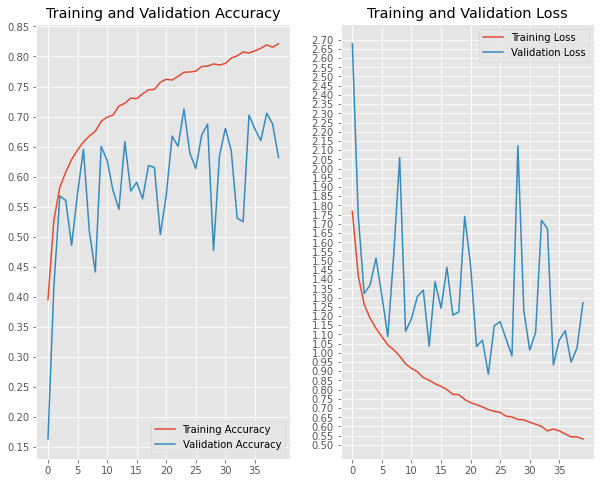

Time taken:  166.3899211883545


In [ ]:
model_performance(model_a_norm_fit)

The validation curve is clearly very volatile. One of the potential reasons could be that the learnign rate is too high, given that the convolution layer outputs are now normalized. Hence, another round of experiment is conducted with a lower learning rate. 

In [ ]:
model_a_norm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
start = time.time()
model_a_norm_fit = model_a_norm.fit(train_batch_ds, 
                              validation_data = val_batch_ds, 
                              epochs = 40)
end = time.time()

Epoch 1/40
233/233 [==============================] - 7s 17ms/step - loss: 2.0934 - accuracy: 0.2773 - val_loss: 2.2965 - val_accuracy: 0.1641
Epoch 2/40
233/233 [==============================] - 3s 14ms/step - loss: 1.8499 - accuracy: 0.4034 - val_loss: 2.0779 - val_accuracy: 0.2620
Epoch 3/40
233/233 [==============================] - 3s 14ms/step - loss: 1.7100 - accuracy: 0.4518 - val_loss: 1.7063 - val_accuracy: 0.4497
Epoch 4/40
233/233 [==============================] - 4s 16ms/step - loss: 1.5954 - accuracy: 0.4939 - val_loss: 1.5876 - val_accuracy: 0.4954
Epoch 5/40
233/233 [==============================] - 4s 15ms/step - loss: 1.4994 - accuracy: 0.5232 - val_loss: 1.4858 - val_accuracy: 0.5363
Epoch 6/40
233/233 [==============================] - 4s 14ms/step - loss: 1.4300 - accuracy: 0.5455 - val_loss: 1.4671 - val_accuracy: 0.5320
Epoch 7/40
233/233 [==============================] - 4s 17ms/step - loss: 1.3781 - accuracy: 0.5552 - val_loss: 1.4073 - val_accuracy: 0.5460

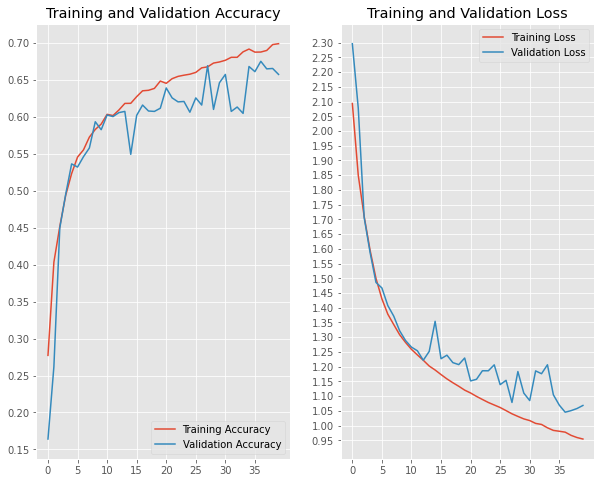

Time taken:  173.04737520217896


In [ ]:
model_performance(model_a_norm_fit)

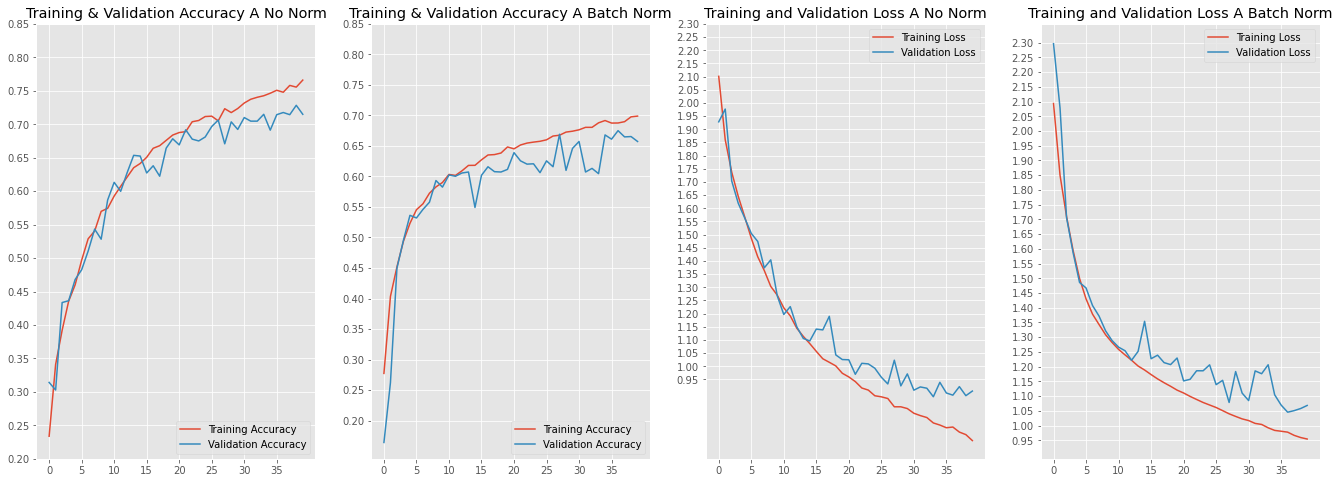

In [ ]:
model_performance_two(model_a_avg_fit, 'A No Norm', model_a_norm_fit, 'A Batch Norm')

With a lower learning rate, the validation curves are less volatile and resemble the shape of the base validation curve. A learning rate of 0.0001 will also be used for the experiment with model VGG-B

In [ ]:
"""
Model VGG-B: 3 blocks of Convolution-Batch Normalization-Activation-Max Pooling layers, with 32-64-128 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_b_norm = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.BatchNormalization(),
    layers.Activation(tf.keras.activations.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(tf.keras.activations.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(tf.keras.activations.relu),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_b_norm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
start = time.time()
model_b_norm_fit = model_b_norm.fit(train_batch_ds, 
                              validation_data = val_batch_ds, 
                              epochs = 25)
end = time.time()

Epoch 1/25
233/233 [==============================] - 9s 27ms/step - loss: 1.9168 - accuracy: 0.3508 - val_loss: 2.3681 - val_accuracy: 0.1533
Epoch 2/25
233/233 [==============================] - 6s 24ms/step - loss: 1.6179 - accuracy: 0.4773 - val_loss: 2.0231 - val_accuracy: 0.2620
Epoch 3/25
233/233 [==============================] - 6s 26ms/step - loss: 1.4696 - accuracy: 0.5280 - val_loss: 1.5605 - val_accuracy: 0.4744
Epoch 4/25
233/233 [==============================] - 6s 25ms/step - loss: 1.3736 - accuracy: 0.5608 - val_loss: 1.4440 - val_accuracy: 0.5137
Epoch 5/25
233/233 [==============================] - 6s 24ms/step - loss: 1.3055 - accuracy: 0.5834 - val_loss: 1.4031 - val_accuracy: 0.5352
Epoch 6/25
233/233 [==============================] - 6s 26ms/step - loss: 1.2545 - accuracy: 0.6054 - val_loss: 1.2789 - val_accuracy: 0.5880
Epoch 7/25
233/233 [==============================] - 6s 26ms/step - loss: 1.2098 - accuracy: 0.6157 - val_loss: 1.2338 - val_accuracy: 0.6100

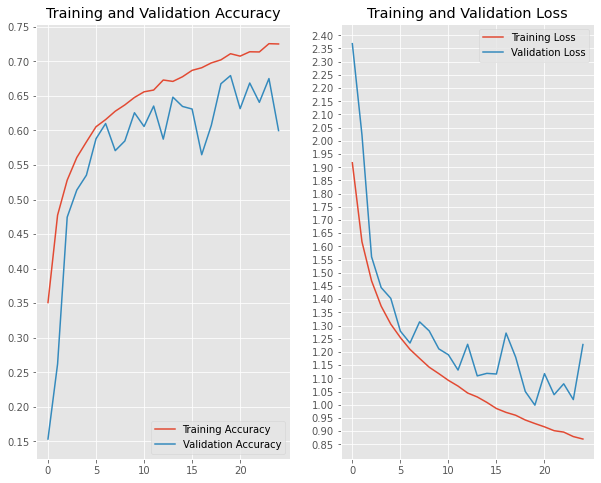

Time taken:  186.06181645393372


In [ ]:
model_performance(model_b_norm_fit)

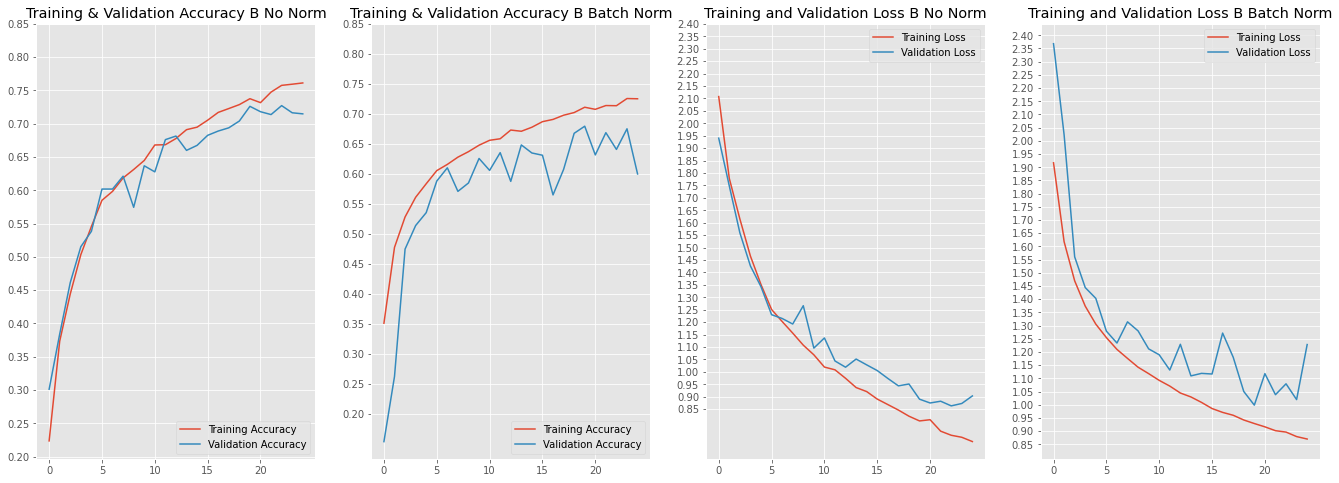

In [ ]:
model_performance_two(model_b_avg_fit, 'B No Norm', model_b_norm_fit, 'B Batch Norm')

### Conclusion

The batch normalization layers is not able to improve perfomance in terms of accuracy even with a lower learning rate. It also takes a significantly higher amount of time. Hence, batch normalization is also rejected for the final model. 

## Initializer

The weight initializers were also experimented to see if any changes in weight initializer would produce higher accuracy by providing a better starting point

In [ ]:
tf.keras.backend.clear_session()

The experimented initializers include Glorot Uniform, He Uniform, and Lecun Uniform. Normal initializers are not included in this notebook since they take longer and thus were eliminated. 

### Glorot Uniform (Default)

Glorot Uniform is the default initializer. The two best models found so far containing the global average pooling layers that use glorot uniform initializers are re-printed below. 

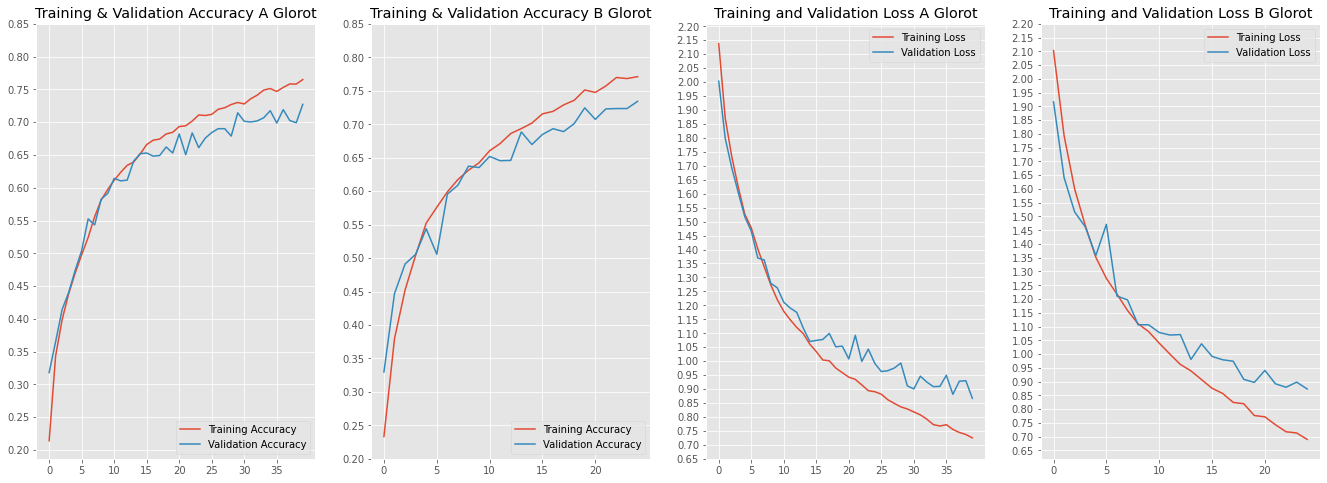

In [ ]:
model_performance_two(model_a_avg_fit, 'A Glorot', model_b_avg_fit, 'B Glorot')

### He Uniform

In [ ]:
"""
Model VGG-A: 3 blocks of Convolution-Activation-Max Pooling layers, with 16-32-64 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_a_he = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),    #weight initializer specified in each conv2D layer 
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_a_he.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
start = time.time()
model_a_he_fit = model_a_he.fit(train_batch_ds, 
                                    validation_data = val_batch_ds, 
                                    epochs = 40)
end = time.time()

Epoch 1/40
233/233 [==============================] - 6s 19ms/step - loss: 1.9989 - accuracy: 0.2865 - val_loss: 1.8345 - val_accuracy: 0.3609
Epoch 2/40
233/233 [==============================] - 4s 16ms/step - loss: 1.6737 - accuracy: 0.4264 - val_loss: 1.6274 - val_accuracy: 0.4626
Epoch 3/40
233/233 [==============================] - 4s 16ms/step - loss: 1.4969 - accuracy: 0.4917 - val_loss: 1.4041 - val_accuracy: 0.5196
Epoch 4/40
233/233 [==============================] - 4s 18ms/step - loss: 1.3513 - accuracy: 0.5534 - val_loss: 1.2811 - val_accuracy: 0.5756
Epoch 5/40
233/233 [==============================] - 4s 17ms/step - loss: 1.2345 - accuracy: 0.5969 - val_loss: 1.2486 - val_accuracy: 0.5939
Epoch 6/40
233/233 [==============================] - 4s 16ms/step - loss: 1.1643 - accuracy: 0.6162 - val_loss: 1.1639 - val_accuracy: 0.6057
Epoch 7/40
233/233 [==============================] - 4s 18ms/step - loss: 1.0965 - accuracy: 0.6391 - val_loss: 1.0880 - val_accuracy: 0.6477

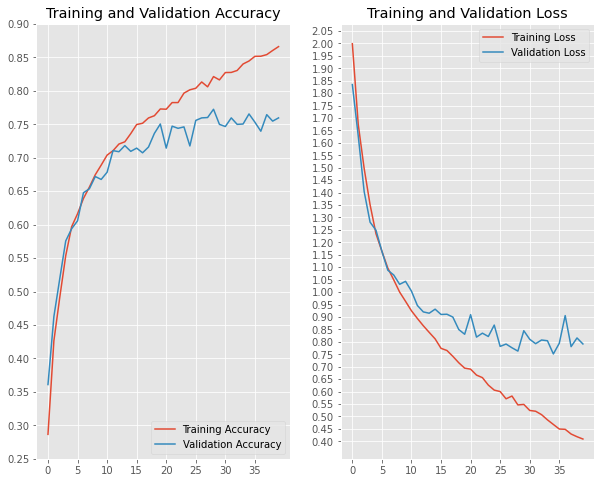

Time taken:  172.69886112213135


In [ ]:
model_performance(model_a_he_fit)

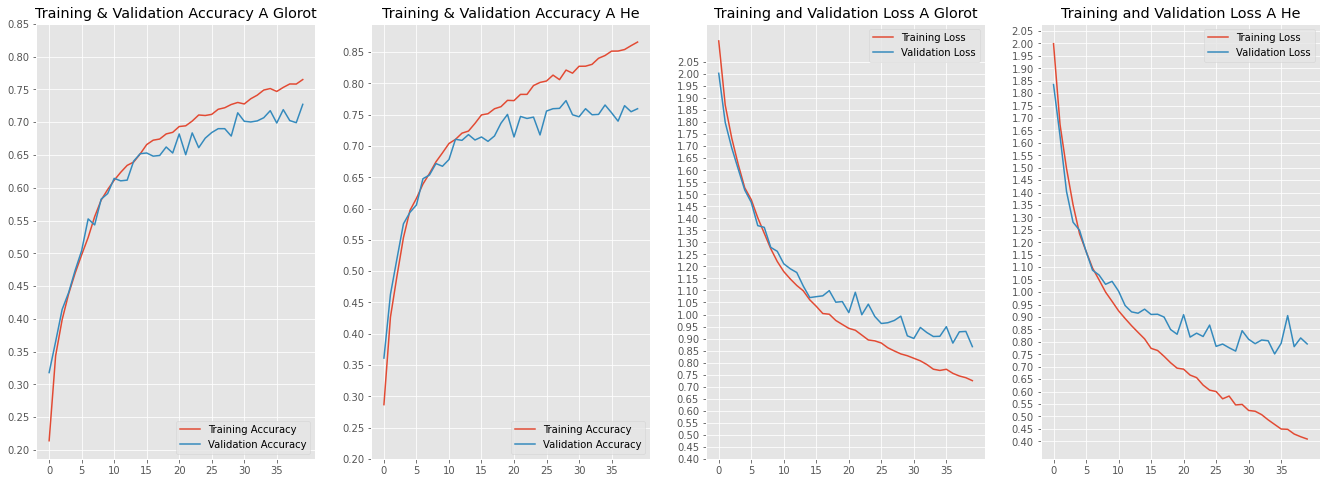

In [ ]:
model_performance_two(model_a_avg_fit, 'A Glorot', model_a_he_fit, 'A He')

He Uniform presents a higher accuracy (and lower loss) in comparison to the original model. However, it also seems to run into overfitting. 

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
"""
Model B: 3 blocks of Convolution-Max Pooling layers, with 32-64-128 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_b_he = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_b_he.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
start = time.time()
model_b_he_fit = model_b_he.fit(train_batch_ds, 
                                    validation_data = val_batch_ds, 
                                    epochs = 25)
end = time.time()

Epoch 1/25
233/233 [==============================] - 6s 19ms/step - loss: 1.9825 - accuracy: 0.2907 - val_loss: 1.8024 - val_accuracy: 0.3997
Epoch 2/25
233/233 [==============================] - 4s 17ms/step - loss: 1.6389 - accuracy: 0.4439 - val_loss: 1.5689 - val_accuracy: 0.4701
Epoch 3/25
233/233 [==============================] - 4s 18ms/step - loss: 1.4603 - accuracy: 0.5165 - val_loss: 1.4110 - val_accuracy: 0.5299
Epoch 4/25
233/233 [==============================] - 4s 17ms/step - loss: 1.3051 - accuracy: 0.5643 - val_loss: 1.2334 - val_accuracy: 0.5901
Epoch 5/25
233/233 [==============================] - 4s 17ms/step - loss: 1.1983 - accuracy: 0.6076 - val_loss: 1.1809 - val_accuracy: 0.6122
Epoch 6/25
233/233 [==============================] - 5s 19ms/step - loss: 1.1261 - accuracy: 0.6348 - val_loss: 1.1450 - val_accuracy: 0.6364
Epoch 7/25
233/233 [==============================] - 4s 17ms/step - loss: 1.0851 - accuracy: 0.6482 - val_loss: 1.1342 - val_accuracy: 0.6299

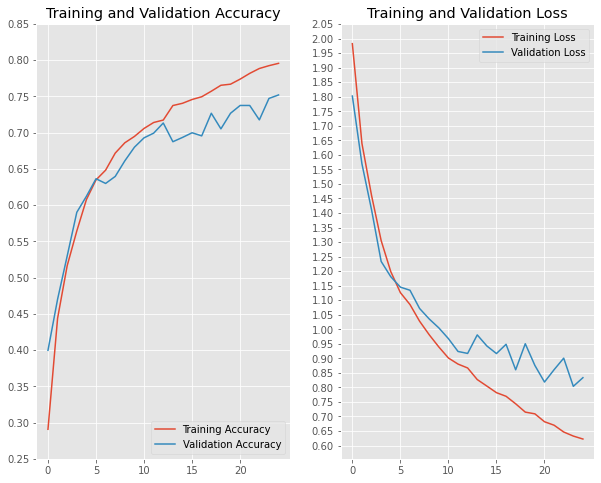

Time taken:  115.86301255226135


In [ ]:
model_performance(model_b_he_fit)

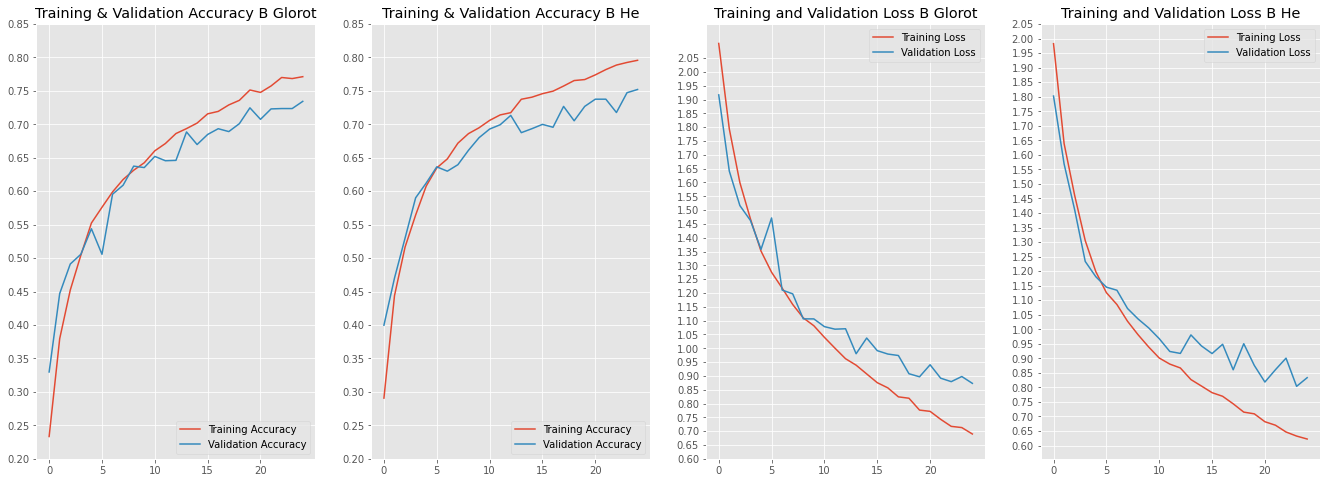

In [ ]:
model_performance_two(model_b_avg_fit, 'B Glorot', model_b_he_fit, 'B He')

He Uniform improves accuracy (and loss function) for Model VGG-B without running into overfitting like VGG-A. 

### Lecun Uniform

In [ ]:
"""
Model A: 3 blocks of Convolution-Max Pooling layers, with 16-32-64 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_a_lecun = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(16, 3, padding='same', activation = 'relu', kernel_initializer = 'lecun_uniform'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'lecun_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'lecun_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_a_lecun.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
start = time.time()
model_a_lecun_fit = model_a_lecun.fit(train_batch_ds, 
                                      validation_data = val_batch_ds, 
                                      epochs = 40)
end = time.time()

Epoch 1/40
233/233 [==============================] - 4s 11ms/step - loss: 2.0500 - accuracy: 0.2603 - val_loss: 1.9083 - val_accuracy: 0.3195
Epoch 2/40
233/233 [==============================] - 3s 11ms/step - loss: 1.8008 - accuracy: 0.3676 - val_loss: 1.7321 - val_accuracy: 0.3889
Epoch 3/40
233/233 [==============================] - 3s 10ms/step - loss: 1.6592 - accuracy: 0.4222 - val_loss: 1.6034 - val_accuracy: 0.4588
Epoch 4/40
233/233 [==============================] - 2s 10ms/step - loss: 1.5595 - accuracy: 0.4615 - val_loss: 1.5671 - val_accuracy: 0.4744
Epoch 5/40
233/233 [==============================] - 3s 11ms/step - loss: 1.4571 - accuracy: 0.5056 - val_loss: 1.4158 - val_accuracy: 0.5331
Epoch 6/40
233/233 [==============================] - 3s 14ms/step - loss: 1.3816 - accuracy: 0.5298 - val_loss: 1.3897 - val_accuracy: 0.5250
Epoch 7/40
233/233 [==============================] - 4s 17ms/step - loss: 1.3252 - accuracy: 0.5516 - val_loss: 1.4311 - val_accuracy: 0.5024

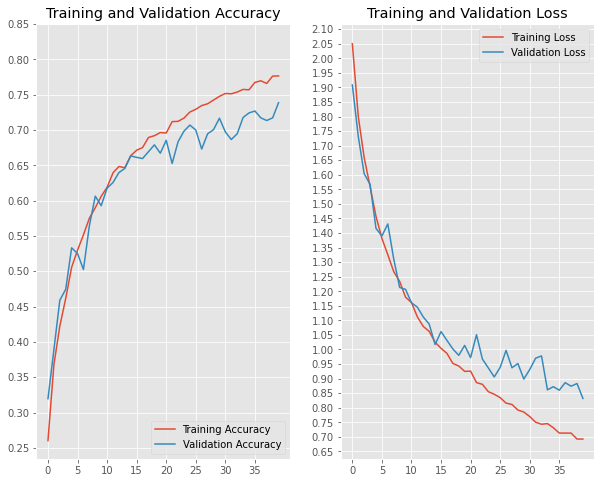

Time taken:  126.82614636421204


In [ ]:
model_performance(model_a_lecun_fit)

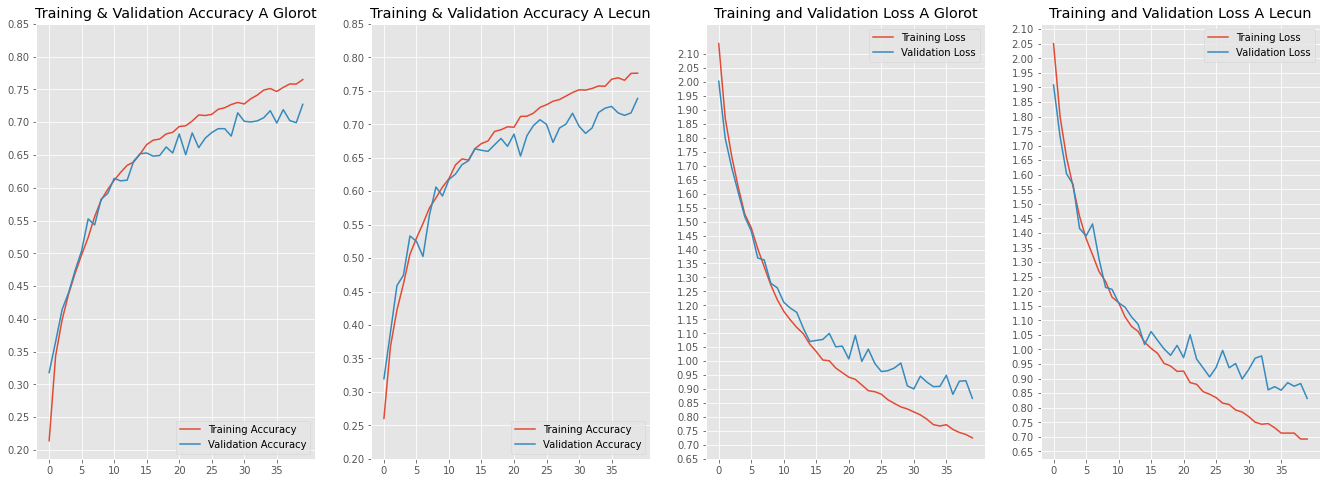

In [ ]:
model_performance_two(model_a_avg_fit, 'A Glorot', model_a_lecun_fit, 'A Lecun')

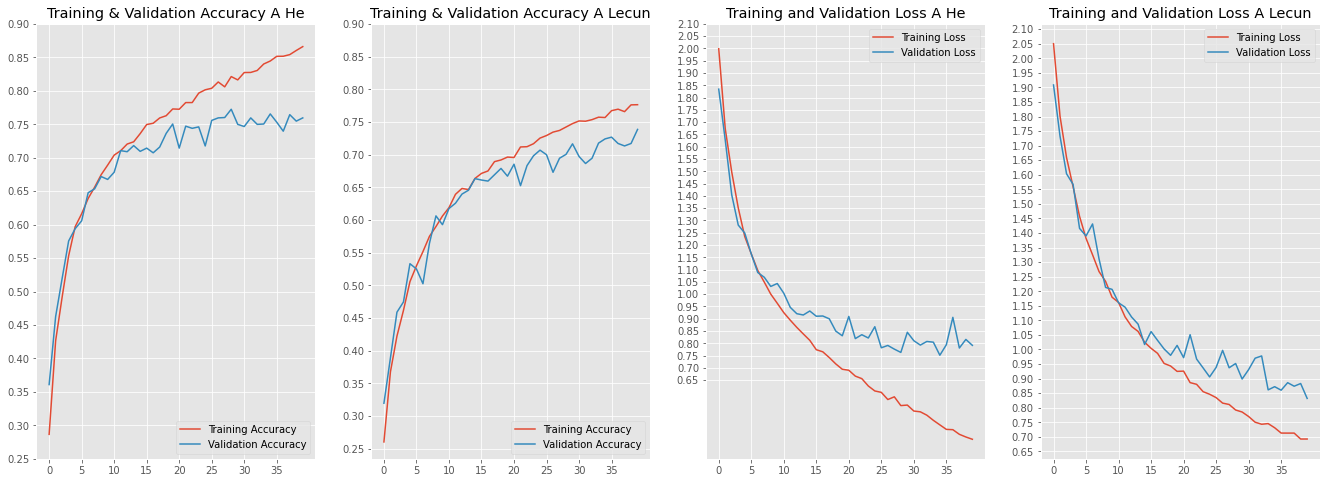

In [ ]:
model_performance_two(model_a_he_fit, 'A He', model_a_lecun_fit, 'A Lecun')

Lecun Uniform results in better accuracy than Glorot Uniform, however, Lecun Uniform also took a longer training time. When comparing to He, He Uniform  has higher accuracy than Lecun, but Lecun has less overfitting. 

In [ ]:
"""
Model B: 3 blocks of Convolution-Max Pooling layers, with 32-64-128 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_b_lecun = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'lecun_uniform'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'lecun_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'lecun_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_b_lecun.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
start = time.time()
model_b_lecun_fit = model_b_lecun.fit(train_batch_ds, 
                                      validation_data = val_batch_ds, 
                                      epochs = 40)
end = time.time()

Epoch 1/40
233/233 [==============================] - 6s 17ms/step - loss: 2.0385 - accuracy: 0.2622 - val_loss: 1.8662 - val_accuracy: 0.3341
Epoch 2/40
233/233 [==============================] - 4s 16ms/step - loss: 1.7159 - accuracy: 0.4069 - val_loss: 1.6457 - val_accuracy: 0.4680
Epoch 3/40
233/233 [==============================] - 4s 18ms/step - loss: 1.5230 - accuracy: 0.4869 - val_loss: 1.4496 - val_accuracy: 0.5143
Epoch 4/40
233/233 [==============================] - 4s 16ms/step - loss: 1.3690 - accuracy: 0.5357 - val_loss: 1.3167 - val_accuracy: 0.5686
Epoch 5/40
233/233 [==============================] - 4s 16ms/step - loss: 1.2738 - accuracy: 0.5826 - val_loss: 1.3227 - val_accuracy: 0.5600
Epoch 6/40
233/233 [==============================] - 4s 19ms/step - loss: 1.1901 - accuracy: 0.6060 - val_loss: 1.1916 - val_accuracy: 0.6052
Epoch 7/40
233/233 [==============================] - 4s 16ms/step - loss: 1.1383 - accuracy: 0.6273 - val_loss: 1.1269 - val_accuracy: 0.6434

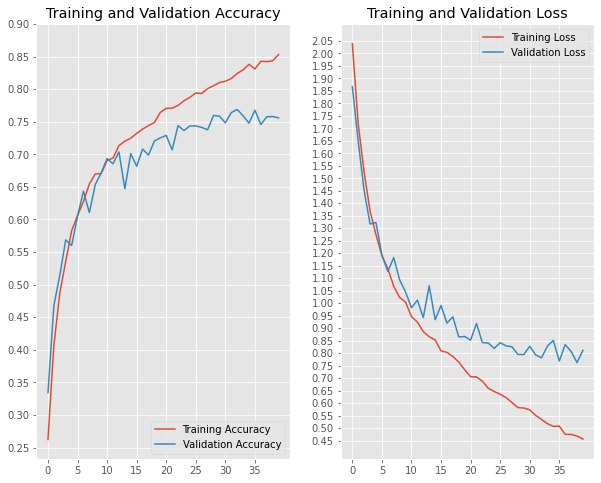

Time taken:  188.6235966682434


In [ ]:
model_performance(model_b_lecun_fit)

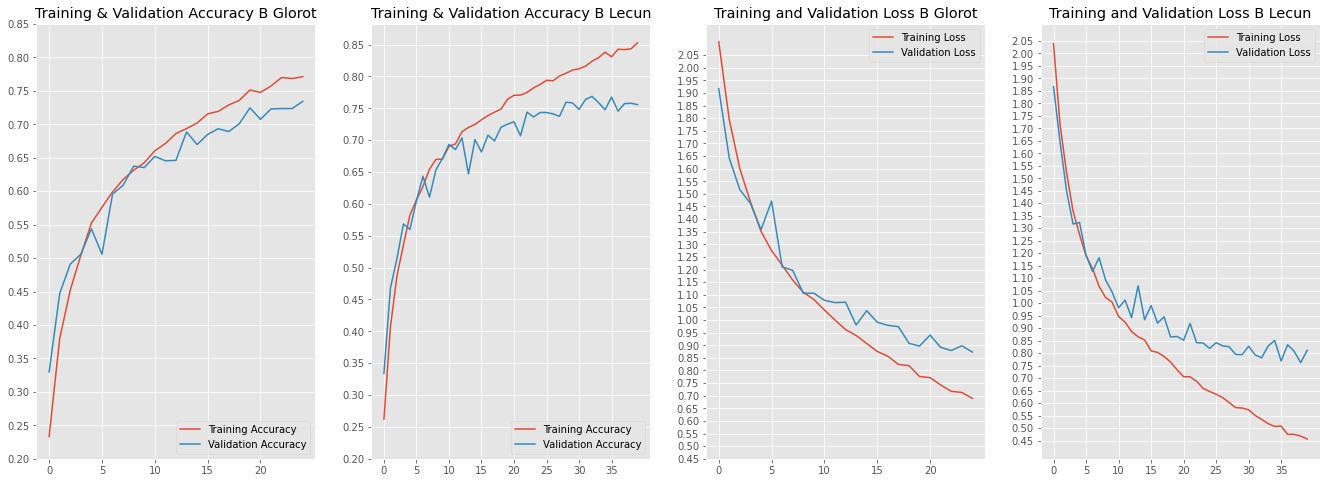

In [ ]:
model_performance_two(model_b_avg_fit, 'B Glorot', model_b_lecun_fit, 'B Lecun')

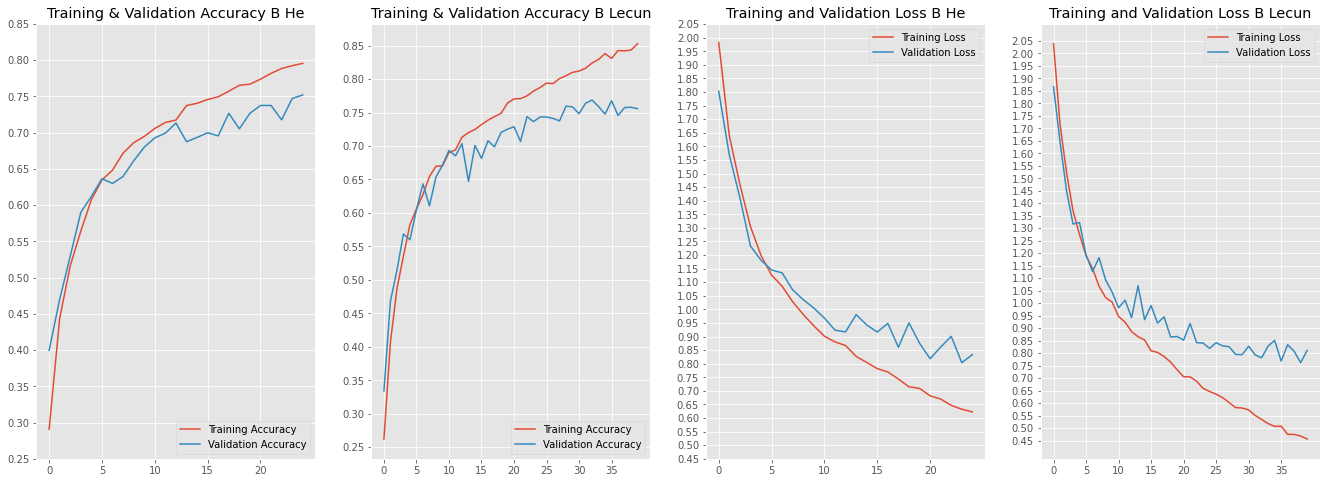

In [ ]:
model_performance_two(model_b_he_fit, 'B He', model_b_lecun_fit, 'B Lecun')

Lecun Uniform results in better accuracy than Glorot Uniform, however, Lecun Uniform also took a longer training time. When comparing to He, He Uniform  has higher accuracy and less overfitting than Lecun (opposite of what was seen in model A)

### Conclusion

The VGG-B Model with He Uniform initializer has the best performance, in terms of increasing accuracy without overfititng. Therefore, 
<br> 1) He Uniform is concluded to be the best initializer 
<br> 2) VGG-A also has the best accuracy with He Uniform initializer, but seems to be mode overfitted. Hence, the VGG-A model is dropped and only the VGG-B model (with global average pooling & He Uniform initializer) will be taken further. 

## Activation Function

The activation function can sometimes be fine tuned to further improve accuracy. This section will test out some of the activation functions that were found to be relatively high performing, while also having faster convergence. Note that here onwards, the experimented will only be conducted on the best model so far: VGG-B model with global average pooling and He Uniform initializer

In [ ]:
tf.keras.backend.clear_session()

### ReLu + tanh (Last Layer)

Firstly, the activation function after the 2nd last Dense FC layer (with 128 inputs) is changed to tanh. Since tanh produces outputs that are 0 valued, it is possible that it may improve the performance by acting as a layer to standardize these values before softmax is applied.

In [ ]:
"""
Model B: 3 blocks of Convolution-Max Pooling layers, with 32-64-128 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_b_tanh = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_b_tanh.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
start = time.time()
model_b_tanh_fit = model_b_tanh.fit(train_batch_ds,
                                    validation_data = val_batch_ds, 
                                    epochs = 25)
end = time.time()

Epoch 1/25
233/233 [==============================] - 6s 18ms/step - loss: 1.9586 - accuracy: 0.3079 - val_loss: 1.7301 - val_accuracy: 0.4104
Epoch 2/25
233/233 [==============================] - 4s 17ms/step - loss: 1.6042 - accuracy: 0.4449 - val_loss: 1.4966 - val_accuracy: 0.4755
Epoch 3/25
233/233 [==============================] - 4s 18ms/step - loss: 1.3804 - accuracy: 0.5354 - val_loss: 1.2865 - val_accuracy: 0.5750
Epoch 4/25
233/233 [==============================] - 4s 18ms/step - loss: 1.2563 - accuracy: 0.5795 - val_loss: 1.2299 - val_accuracy: 0.5896
Epoch 5/25
233/233 [==============================] - 4s 17ms/step - loss: 1.1745 - accuracy: 0.6160 - val_loss: 1.1435 - val_accuracy: 0.6229
Epoch 6/25
233/233 [==============================] - 4s 16ms/step - loss: 1.0948 - accuracy: 0.6400 - val_loss: 1.0751 - val_accuracy: 0.6493
Epoch 7/25
233/233 [==============================] - 4s 16ms/step - loss: 1.0449 - accuracy: 0.6566 - val_loss: 1.0673 - val_accuracy: 0.6455

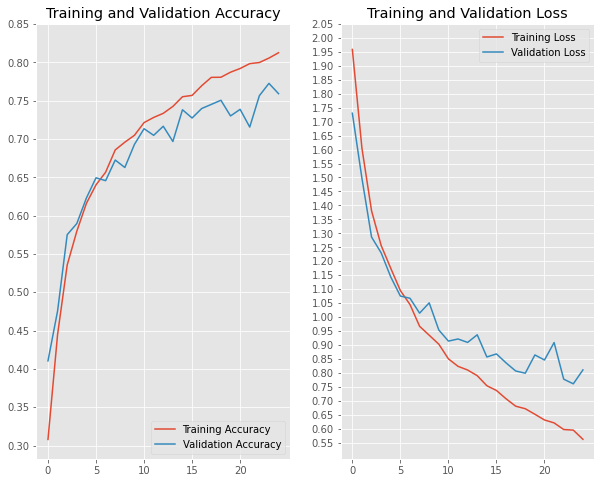

Time taken:  107.52484917640686


In [ ]:
model_performance(model_b_tanh_fit)

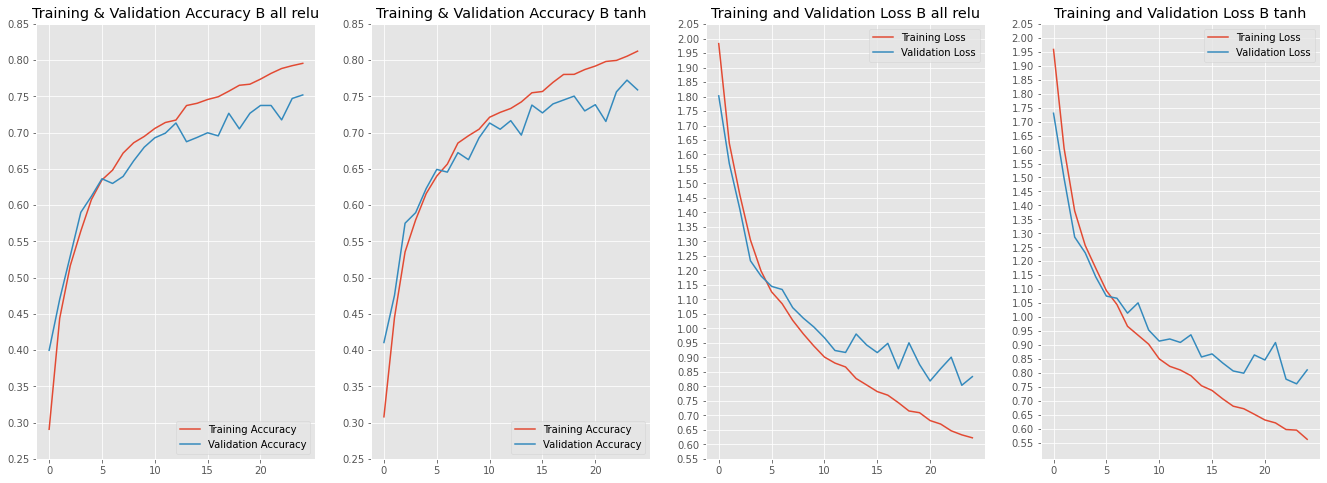

In [ ]:
model_performance_two(model_b_he_fit, 'B all relu', model_b_tanh_fit, 'B tanh')

As seen above, changing activation function of the 2nd last FC layer to tanh indeed helps to slightly improve the performance in accuracy and loss. This also did not change the training time, hence the 2nd last FC layer will use tanh from here onwards.

### Elu

Elu is another activation function that can perform well and converge faster. It also smooths out slower than ReLU, preventing gradients from boosting up too much.

In [ ]:
"""
Model B: 3 blocks of Convolution-Max Pooling layers, with 32-64-128 convolution filters 
The FC layers include: a Global Average Pooling layer to flatten all the outputs, followed by a dense layer of 128 units and a softmax layer 
"""
model_b_elu = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation = 'elu'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation = 'elu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation = 'elu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(len(class_names), activation='softmax')   
])

In [ ]:
model_b_elu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
start = time.time()
model_b_elu_fit = model_b_elu.fit(train_batch_ds,
                                    validation_data = val_batch_ds, 
                                    epochs = 25)
end = time.time()

Epoch 1/25
233/233 [==============================] - 7s 21ms/step - loss: 2.0387 - accuracy: 0.2614 - val_loss: 1.8838 - val_accuracy: 0.3556
Epoch 2/25
233/233 [==============================] - 5s 19ms/step - loss: 1.7949 - accuracy: 0.3710 - val_loss: 1.6807 - val_accuracy: 0.4207
Epoch 3/25
233/233 [==============================] - 5s 20ms/step - loss: 1.5617 - accuracy: 0.4617 - val_loss: 1.5168 - val_accuracy: 0.4863
Epoch 4/25
233/233 [==============================] - 5s 19ms/step - loss: 1.4256 - accuracy: 0.5192 - val_loss: 1.3999 - val_accuracy: 0.5218
Epoch 5/25
233/233 [==============================] - 5s 19ms/step - loss: 1.3162 - accuracy: 0.5637 - val_loss: 1.3284 - val_accuracy: 0.5551
Epoch 6/25
233/233 [==============================] - 5s 21ms/step - loss: 1.2370 - accuracy: 0.5898 - val_loss: 1.2830 - val_accuracy: 0.5750
Epoch 7/25
233/233 [==============================] - 5s 19ms/step - loss: 1.1752 - accuracy: 0.6068 - val_loss: 1.2057 - val_accuracy: 0.6127

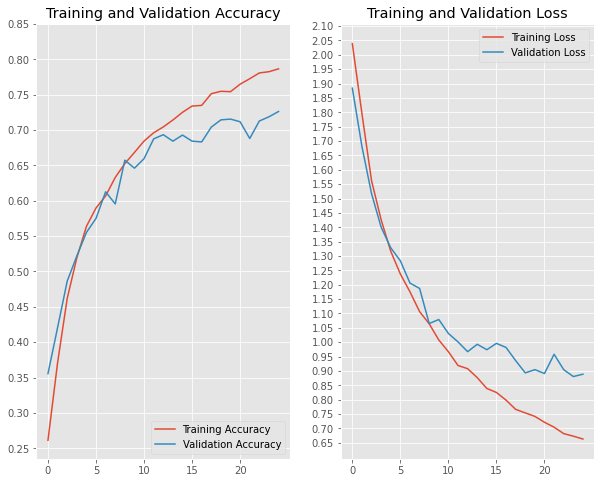

Time taken:  124.13263726234436


In [ ]:
model_performance(model_b_elu_fit)

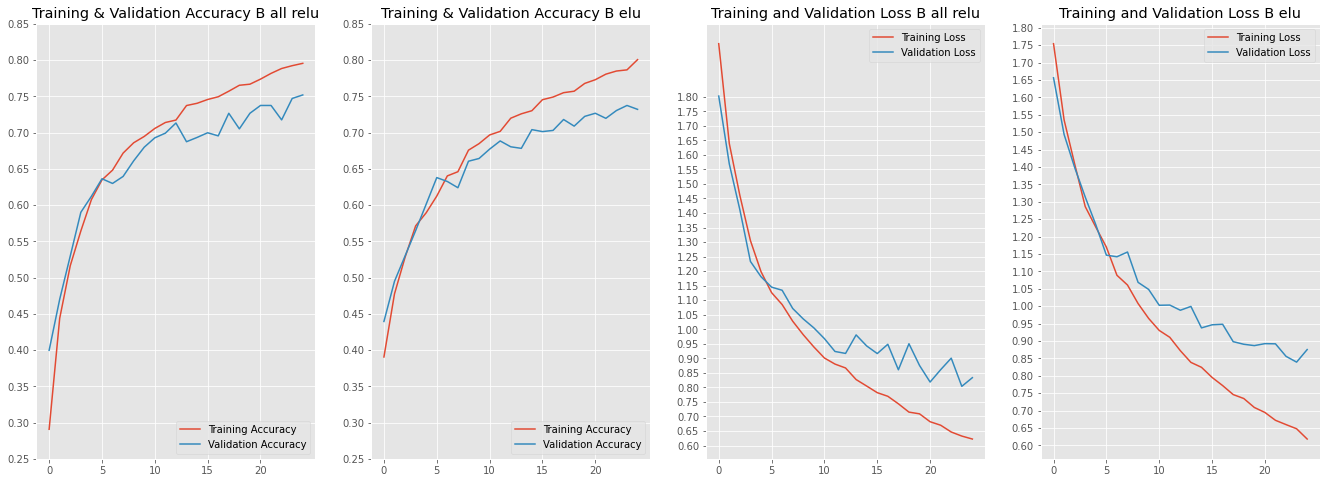

In [ ]:
model_performance_two(model_b_he_fit, 'B all relu', model_b_elu_fit, 'B elu')

Relu + tanh outperforms Elu + tanh in terms of accuracy. Furthermore, Elu also takes a longer time to train. 

### Conclusion

ReLu layer will still be kept due to it's training time and higher performance. However, the activation layer that follows the 2nd last FC Dense layer will use tanh function instead of ReLu.

##Learning Rate

So far all the techniques explored above mainly emphasized on improving accuracy and reducing overfitting. The training times could be further improved, which may also consequently result in better convergence values, by exploring the right kind of learning rates

In [ ]:
tf.keras.backend.clear_session()

Training time of ~100s is aimed, to account for the additional training time that the first epoch can take, especially when restarting the runtime. Hence, the number of epochs for the experiments at this stage have been reduced to 23. In short, the goal is to get the best possible converge in 23 epochs in about 100s. 

### Fixed-Rate (with ADAM)

Here is the best model that has been concluded based on the previous experiments so far.

In [ ]:
model_x = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(len(class_names), activation='softmax')   
])

One of the most straightforward ways is to use a fixed learning rate (specifically, alpha value) along with ADAM's moving average/moment vectors. A hyperparameter search can be conducted for a range of learning rates using Keras Tuner as shown below to find the best fixed learning rate.

In [ ]:
## define a function that returns a model with the parameters and values to be tested 
def build_model(hp): 
  #model layer is built with some of the parameters containing a range of values for the parameter search
  model = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),    #padding = 'same' is used to keep the shape of 128 by 128 pixels maintain and avoid loss of information
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(len(class_names), activation='softmax')   
])

  hp_learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value = 0.005)   #range of learning rate to test out 

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),       #compiling the model
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

In [ ]:
## define Bayesian Optimization tuner - uses Bayesian probability to converge to better performing hyperparamter (in this case learning rate)
tuner = kt.BayesianOptimization(build_model,
                     objective='val_accuracy',      #objective metric when choosing the best hyperparamter
                     max_trials = 20)               #max number of models to try (to avoid running too long)      

In [ ]:
tuner.search(train_batch_ds, validation_data=val_batch_ds, epochs = 23)     #perform the search, by training the trial model for 23 epochs

Trial 20 Complete [00h 01m 45s]
val_accuracy: 0.7810651063919067

Best val_accuracy So Far: 0.7923614978790283
Total elapsed time: 00h 34m 45s


In [ ]:
#get the best learning rate
best_lr = tuner.get_best_hyperparameters(num_trials=1)[0].get('learning_rate')  

best_lr

0.00250751452220195

In [ ]:
#compile the model with the best learning rate returned
model_x.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
#train the model with the best learning rate returned
model_x_fit = model_x.fit(train_batch_ds, 
                          validation_data = val_batch_ds, 
                          epochs = 23)

Epoch 1/23
233/233 [==============================] - 7s 19ms/step - loss: 1.9290 - accuracy: 0.3141 - val_loss: 1.6516 - val_accuracy: 0.4481
Epoch 2/23
233/233 [==============================] - 4s 16ms/step - loss: 1.4955 - accuracy: 0.4901 - val_loss: 1.3488 - val_accuracy: 0.5433
Epoch 3/23
233/233 [==============================] - 4s 18ms/step - loss: 1.2591 - accuracy: 0.5786 - val_loss: 1.1840 - val_accuracy: 0.6116
Epoch 4/23
233/233 [==============================] - 4s 17ms/step - loss: 1.1373 - accuracy: 0.6267 - val_loss: 1.1373 - val_accuracy: 0.6218
Epoch 5/23
233/233 [==============================] - 4s 16ms/step - loss: 1.0558 - accuracy: 0.6552 - val_loss: 1.0949 - val_accuracy: 0.6557
Epoch 6/23
233/233 [==============================] - 4s 17ms/step - loss: 0.9733 - accuracy: 0.6827 - val_loss: 0.9668 - val_accuracy: 0.6756
Epoch 7/23
233/233 [==============================] - 4s 17ms/step - loss: 0.8960 - accuracy: 0.7027 - val_loss: 0.9851 - val_accuracy: 0.6789

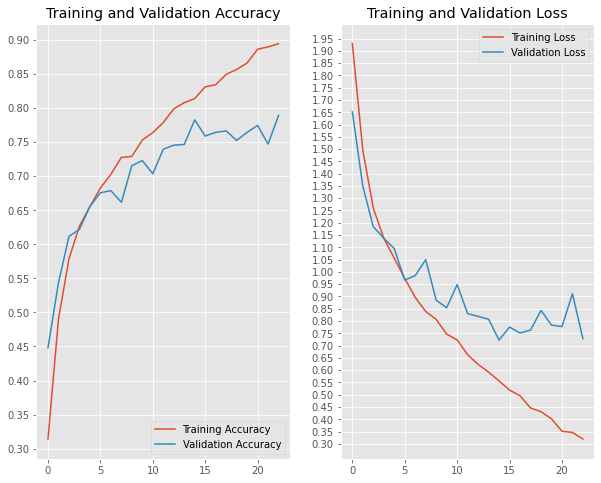

Time taken:  105.20007061958313


In [ ]:
model_performance(model_x_fit)

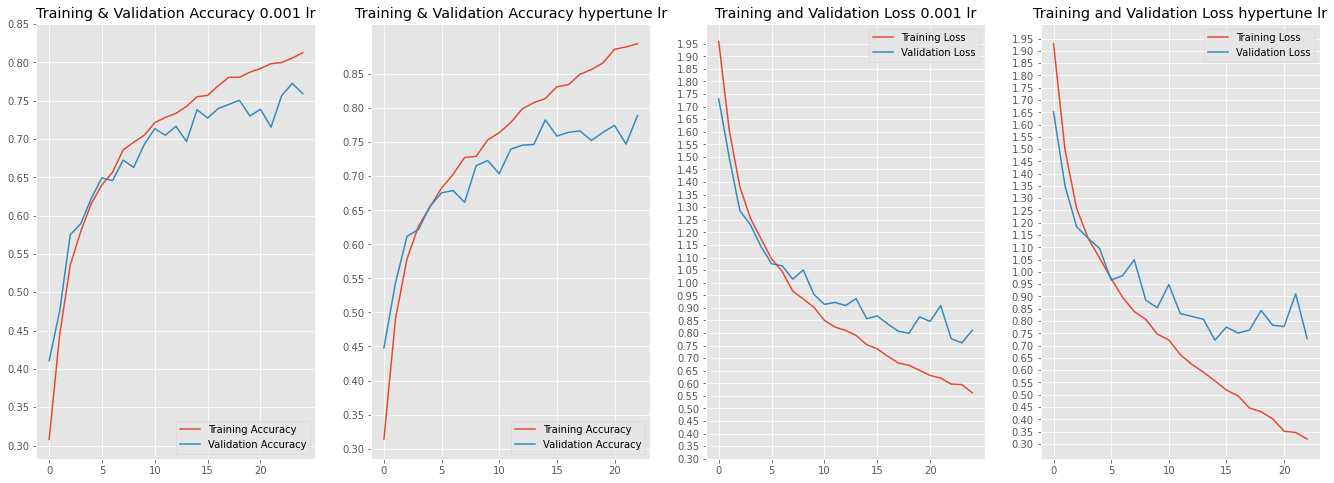

In [ ]:
model_performance_two(model_b_tanh_fit, '0.001 lr', model_x_fit, 'hypertune lr')

The validation accuracy and loss have definitely improved with the fine tuned learning rate. However, the model with a better learning rate seems to be overfitted. Perhaps, this could be improved by using a decaying learning rate, instead of a fixed one. 

### Exponential Decay (with ADAM)

The learning rate could be decreased as the number of epochs increase to produce a smoother convergence at a better minima. One of the methods explored includes an exponential decay. 

A decay function is defined below, with a decay rate of 0.2. Note that since the learning rate will decay, the starting learning rate is set slightly higher than the value returned by the hyperparamter search. 

In [ ]:
def exp_decay(epoch, lr):
  if epoch < 5:       #first 5 epochs constant
     return lr
  else:               #exponential decay after 5 epochs
    return lr * tf.math.exp(-0.2)
lrate = LearningRateScheduler(exp_decay)

In [ ]:
model_x2 = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(10, activation='softmax')   
])

model_x2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),     #slightly higher learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

start = time.time()
model_x2_fit= model_x2.fit(train_batch_ds, 
                       validation_data = val_batch_ds, 
                       epochs = 23, 
                       callbacks = [lrate])
end = time.time()

Epoch 1/23
233/233 [==============================] - 8s 19ms/step - loss: 1.9403 - accuracy: 0.3056 - val_loss: 1.5993 - val_accuracy: 0.4400 - lr: 0.0030
Epoch 2/23
233/233 [==============================] - 6s 24ms/step - loss: 1.4873 - accuracy: 0.4974 - val_loss: 1.4354 - val_accuracy: 0.5100 - lr: 0.0030
Epoch 3/23
233/233 [==============================] - 4s 17ms/step - loss: 1.2890 - accuracy: 0.5617 - val_loss: 1.3972 - val_accuracy: 0.5412 - lr: 0.0030
Epoch 4/23
233/233 [==============================] - 4s 19ms/step - loss: 1.1720 - accuracy: 0.6121 - val_loss: 1.1920 - val_accuracy: 0.6089 - lr: 0.0030
Epoch 5/23
233/233 [==============================] - 4s 18ms/step - loss: 1.0547 - accuracy: 0.6508 - val_loss: 1.1367 - val_accuracy: 0.6299 - lr: 0.0030
Epoch 6/23
233/233 [==============================] - 4s 16ms/step - loss: 0.9441 - accuracy: 0.6915 - val_loss: 0.9959 - val_accuracy: 0.6762 - lr: 0.0025
Epoch 7/23
233/233 [==============================] - 4s 17ms/st

In [ ]:
tf.keras.backend.clear_session()

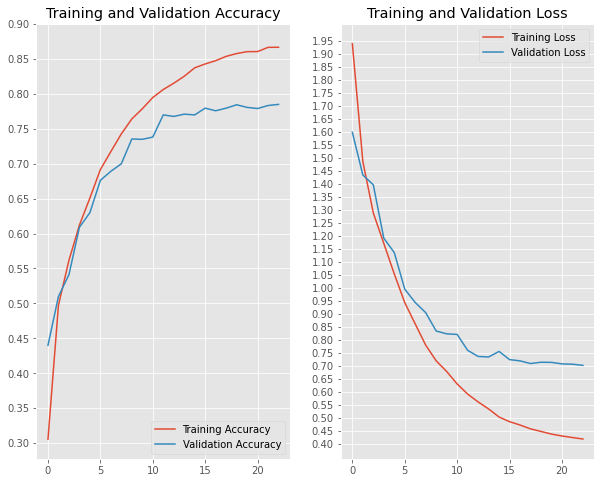

Time taken:  117.25832509994507


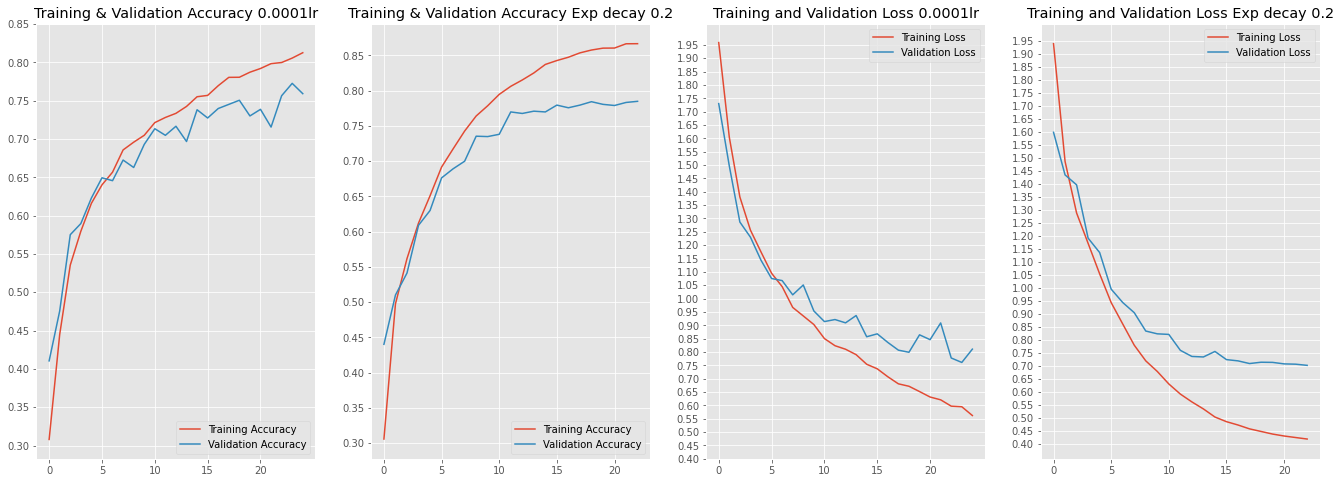

In [ ]:
model_performance(model_x2_fit)
model_performance_two(model_b_tanh_fit, '0.0001lr', model_x2_fit, 'Exp decay 0.2')

Having a decay function definitely improved the accuracy as well as smoothened out the validation curve. However, there still seems to be some overfitting present. The next few trials will experiment with different decay rates and starting learning rates. 

In [ ]:
model_x3 = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(10, activation='softmax')   
])

model_x3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0028), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

start = time.time()
model_x3_fit= model_x3.fit(train_batch_ds, 
                       validation_data = val_batch_ds, 
                       epochs = 23, 
                       callbacks = [lrate])
end = time.time()

Epoch 1/23
233/233 [==============================] - 8s 19ms/step - loss: 1.9427 - accuracy: 0.3134 - val_loss: 1.6692 - val_accuracy: 0.4180 - lr: 0.0028
Epoch 2/23
233/233 [==============================] - 4s 19ms/step - loss: 1.4779 - accuracy: 0.4962 - val_loss: 1.4376 - val_accuracy: 0.5089 - lr: 0.0028
Epoch 3/23
233/233 [==============================] - 4s 18ms/step - loss: 1.2882 - accuracy: 0.5716 - val_loss: 1.2400 - val_accuracy: 0.6041 - lr: 0.0028
Epoch 4/23
233/233 [==============================] - 4s 16ms/step - loss: 1.1915 - accuracy: 0.6045 - val_loss: 1.1339 - val_accuracy: 0.6261 - lr: 0.0028
Epoch 5/23
233/233 [==============================] - 4s 19ms/step - loss: 1.0757 - accuracy: 0.6470 - val_loss: 1.0721 - val_accuracy: 0.6477 - lr: 0.0028
Epoch 6/23
233/233 [==============================] - 4s 16ms/step - loss: 0.9773 - accuracy: 0.6790 - val_loss: 1.0430 - val_accuracy: 0.6595 - lr: 0.0023
Epoch 7/23
233/233 [==============================] - 4s 16ms/st

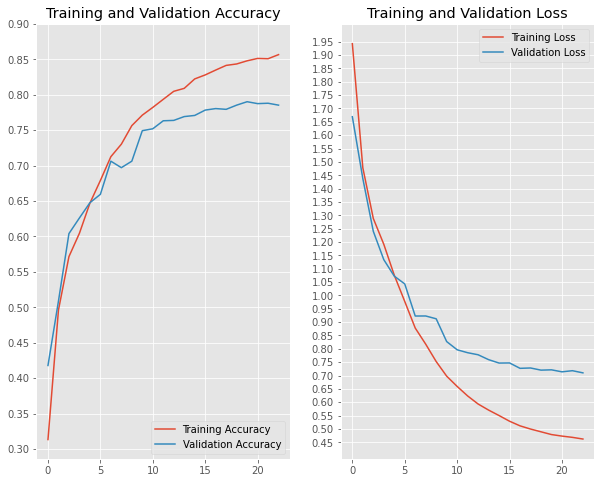

Time taken:  117.93698287010193


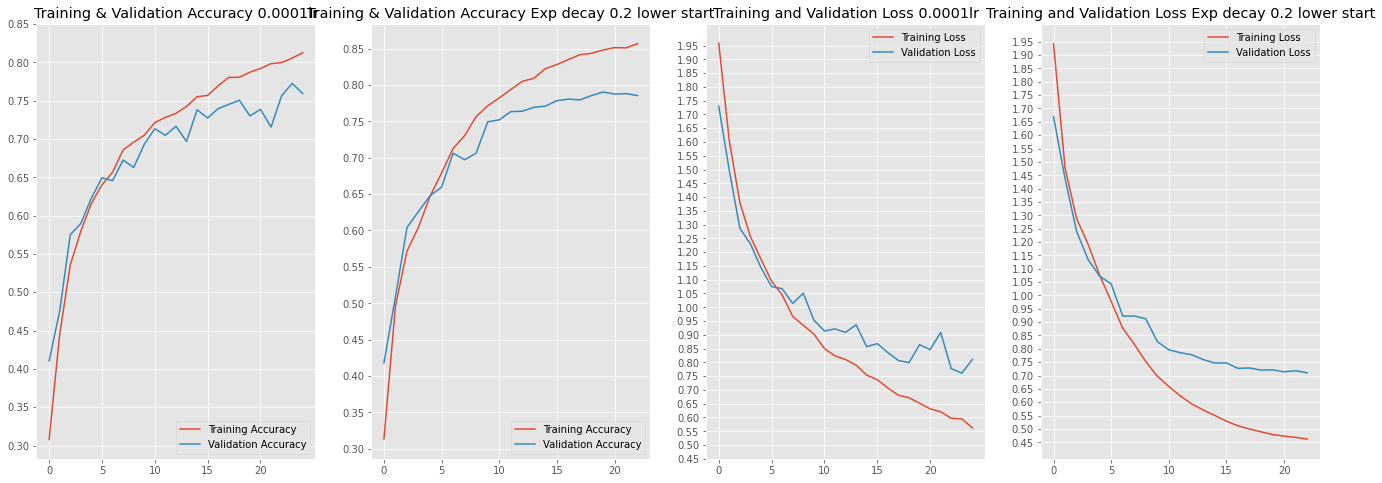

In [ ]:
model_performance(model_x3_fit)
model_performance_two(model_b_tanh_fit, '0.0001lr', model_x3_fit, 'Exp decay 0.2 lower start')

In [ ]:
def exp_decay(epoch, lr):
  if epoch < 5:       #first 5 epochs constant
     return lr
  else:               #exponential decay after 5 epochs
    return lr * tf.math.exp(-0.15)

lrate = LearningRateScheduler(exp_decay)    #learning rate scheduler object created using the defined decay function

In [ ]:
model_x4 = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(10, activation='softmax')   
])

model_x4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0028), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

start = time.time()
model_x4_fit= model_x4.fit(train_batch_ds, 
                       validation_data = val_batch_ds, 
                       epochs = 23, 
                       callbacks = [lrate])   #learning rate decay implemented via a callback 
end = time.time()

Epoch 1/23
233/233 [==============================] - 6s 17ms/step - loss: 1.8825 - accuracy: 0.3284 - val_loss: 1.6856 - val_accuracy: 0.4120 - lr: 0.0028
Epoch 2/23
233/233 [==============================] - 4s 18ms/step - loss: 1.4082 - accuracy: 0.5276 - val_loss: 1.3132 - val_accuracy: 0.5675 - lr: 0.0028
Epoch 3/23
233/233 [==============================] - 5s 20ms/step - loss: 1.2590 - accuracy: 0.5781 - val_loss: 1.2243 - val_accuracy: 0.5901 - lr: 0.0028
Epoch 4/23
233/233 [==============================] - 5s 21ms/step - loss: 1.1553 - accuracy: 0.6224 - val_loss: 1.1253 - val_accuracy: 0.6229 - lr: 0.0028
Epoch 5/23
233/233 [==============================] - 5s 21ms/step - loss: 1.0535 - accuracy: 0.6548 - val_loss: 1.1986 - val_accuracy: 0.6068 - lr: 0.0028
Epoch 6/23
233/233 [==============================] - 5s 19ms/step - loss: 0.9600 - accuracy: 0.6848 - val_loss: 1.0458 - val_accuracy: 0.6659 - lr: 0.0024
Epoch 7/23
233/233 [==============================] - 5s 21ms/st

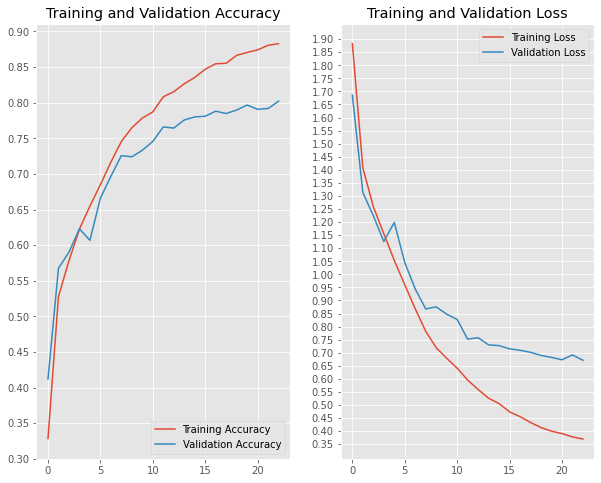

Time taken:  105.23811388015747


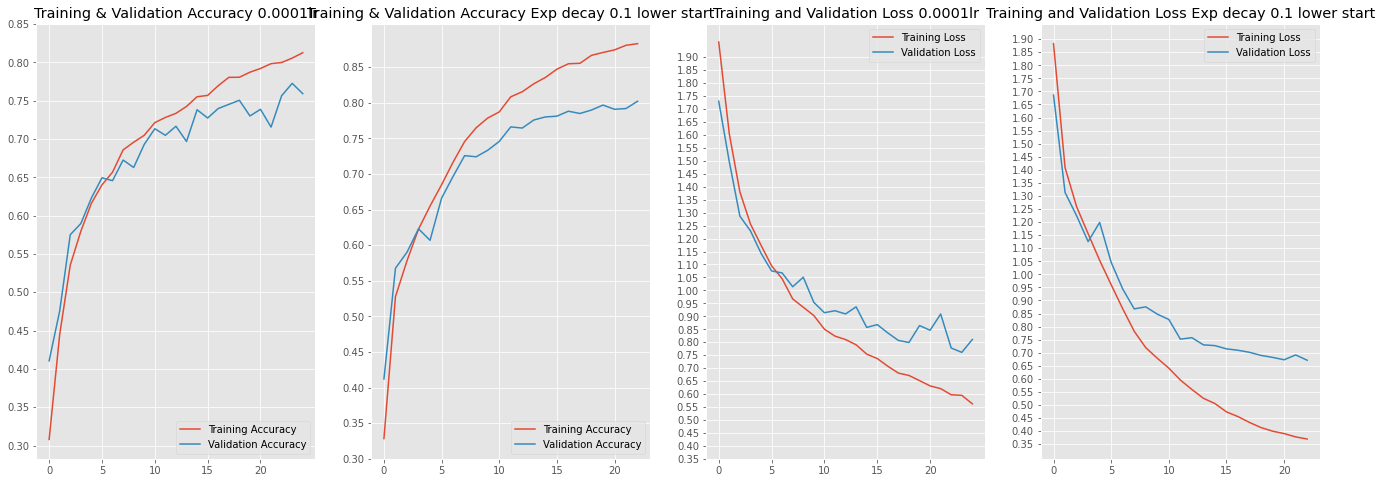

In [ ]:
model_performance(model_x4_fit)
model_performance_two(model_b_tanh_fit, '0.0001lr', model_x4_fit, 'Exp decay 0.1 lower start')

In [ ]:
model_x5 = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(10, activation='softmax')   
])

model_x5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0027), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

start = time.time()
model_x5_fit= model_x5.fit(train_batch_ds, 
                       validation_data = val_batch_ds, 
                       epochs = 23, 
                       callbacks = [lrate])
end = time.time()

Epoch 1/23
233/233 [==============================] - 7s 18ms/step - loss: 1.9277 - accuracy: 0.3137 - val_loss: 1.6775 - val_accuracy: 0.4212 - lr: 0.0027
Epoch 2/23
233/233 [==============================] - 4s 17ms/step - loss: 1.4852 - accuracy: 0.4990 - val_loss: 1.3517 - val_accuracy: 0.5621 - lr: 0.0027
Epoch 3/23
233/233 [==============================] - 4s 16ms/step - loss: 1.2728 - accuracy: 0.5744 - val_loss: 1.2466 - val_accuracy: 0.5686 - lr: 0.0027
Epoch 4/23
233/233 [==============================] - 4s 18ms/step - loss: 1.1393 - accuracy: 0.6240 - val_loss: 1.2029 - val_accuracy: 0.6036 - lr: 0.0027
Epoch 5/23
233/233 [==============================] - 4s 16ms/step - loss: 1.0517 - accuracy: 0.6523 - val_loss: 1.0515 - val_accuracy: 0.6579 - lr: 0.0027
Epoch 6/23
233/233 [==============================] - 4s 16ms/step - loss: 0.9449 - accuracy: 0.6923 - val_loss: 0.9659 - val_accuracy: 0.6918 - lr: 0.0024
Epoch 7/23
233/233 [==============================] - 4s 18ms/st

As shown above, a lower starting learning rate reduced some of the overfitting present. However, it still seems that the validation accuracy keeps bouncing around a small range of values towards the latter epochs. This could perhaps be further improved by incorporate differing decay values at different stages of the training period. 

### Exponential + Step Decay (with ADAM)

A step decay can be incoroporated with exponential decay to enforce the decay function with different rates. Note that several trials were conducted based on the observations made in previous trainings runs validation curves, but only a couple of the experimented values are selected for demonstration purposes. 

In [ ]:
def exp_decay(epoch, lr):
  if epoch < 5:         #no decay for first 5 epochs
    return lr
  elif epoch <=10:
    return lr*tf.math.exp(-0.11)       #decay rate of 0.11 until 10 epochs
  elif epoch <=16:
    return lr*tf.math.exp(-0.14)       #decay rate of 0.14 until 16 epochs
  else: 
    return lr*tf.math.exp(-0.16)        #decay rate of 0.16 17th epoch onwards
lrate = LearningRateScheduler(exp_decay)

In [ ]:
model_exp_step = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(10, activation='softmax')   
])

model_exp_step.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0028), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

start = time.time()
model_exp_step_fit= model_exp_step.fit(train_batch_ds, 
                       validation_data = val_batch_ds, 
                       epochs = 23, 
                       callbacks = [lrate])
end = time.time()

Epoch 1/23
233/233 [==============================] - 6s 19ms/step - loss: 1.9387 - accuracy: 0.3079 - val_loss: 1.7629 - val_accuracy: 0.4169 - lr: 0.0028
Epoch 2/23
233/233 [==============================] - 4s 18ms/step - loss: 1.5043 - accuracy: 0.4921 - val_loss: 1.5431 - val_accuracy: 0.4782 - lr: 0.0028
Epoch 3/23
233/233 [==============================] - 6s 24ms/step - loss: 1.2780 - accuracy: 0.5723 - val_loss: 1.1694 - val_accuracy: 0.6019 - lr: 0.0028
Epoch 4/23
233/233 [==============================] - 6s 24ms/step - loss: 1.1299 - accuracy: 0.6275 - val_loss: 1.2598 - val_accuracy: 0.5949 - lr: 0.0028
Epoch 5/23
233/233 [==============================] - 6s 25ms/step - loss: 1.0303 - accuracy: 0.6618 - val_loss: 1.0899 - val_accuracy: 0.6552 - lr: 0.0028
Epoch 6/23
233/233 [==============================] - 4s 18ms/step - loss: 0.9266 - accuracy: 0.7004 - val_loss: 0.9671 - val_accuracy: 0.6896 - lr: 0.0025
Epoch 7/23
233/233 [==============================] - 5s 23ms/st

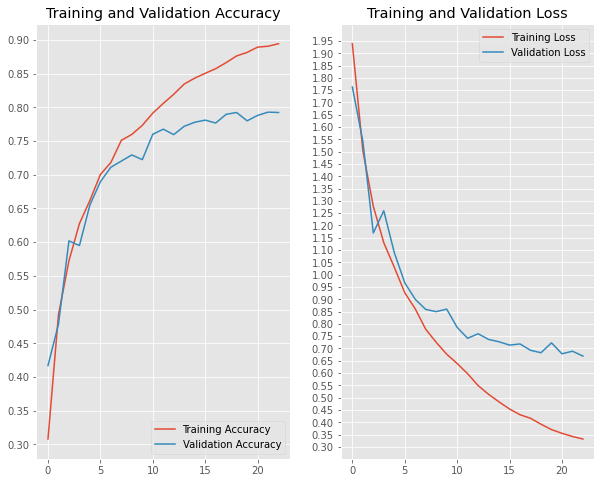

Time taken:  121.85484576225281


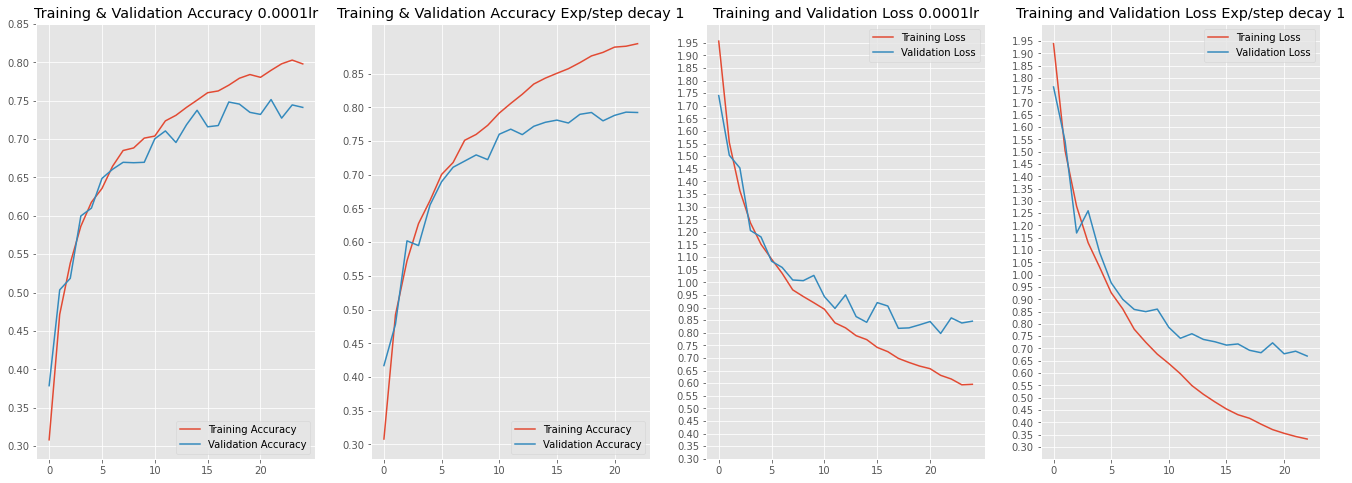

In [ ]:
model_performance(model_exp_step_fit)
model_performance_two(model_b_tanh_fit, '0.0001lr', model_exp_step_fit, 'Exp/step decay 1')

In [ ]:
def exp_decay(epoch, lr):
  if epoch < 5:                   #no decay for first 5 epochs
    return lr
  elif epoch <=10:
    return lr*tf.math.exp(-0.10)  #decay rate of 0.10 until 10 epochs
  elif epoch <=16:
    return lr*tf.math.exp(-0.15)  #decay rate of 0.15 until 16 epochs
  else: 
    return lr*tf.math.exp(-0.20)  #decay rate of 0.20 for 17th epoch onwards
lrate = LearningRateScheduler(exp_decay)  

In [ ]:
model_exp_step2 = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu',kernel_initializer = 'he_uniform'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(10, activation='softmax')   
])

model_exp_step2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0028), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

start = time.time()
model_exp_step2_fit= model_exp_step2.fit(train_batch_ds, 
                       validation_data = val_batch_ds, 
                       epochs = 23, 
                       callbacks = [lrate])
end = time.time()

Epoch 1/23
233/233 [==============================] - 6s 17ms/step - loss: 1.9430 - accuracy: 0.3079 - val_loss: 1.7320 - val_accuracy: 0.3991 - lr: 0.0028
Epoch 2/23
233/233 [==============================] - 4s 19ms/step - loss: 1.5060 - accuracy: 0.4839 - val_loss: 1.4348 - val_accuracy: 0.5100 - lr: 0.0028
Epoch 3/23
233/233 [==============================] - 4s 17ms/step - loss: 1.2736 - accuracy: 0.5696 - val_loss: 1.2059 - val_accuracy: 0.6062 - lr: 0.0028
Epoch 4/23
233/233 [==============================] - 5s 22ms/step - loss: 1.1592 - accuracy: 0.6107 - val_loss: 1.1361 - val_accuracy: 0.6278 - lr: 0.0028
Epoch 5/23
233/233 [==============================] - 5s 21ms/step - loss: 1.0555 - accuracy: 0.6477 - val_loss: 1.1174 - val_accuracy: 0.6321 - lr: 0.0028
Epoch 6/23
233/233 [==============================] - 4s 19ms/step - loss: 0.9641 - accuracy: 0.6782 - val_loss: 1.0657 - val_accuracy: 0.6471 - lr: 0.0025
Epoch 7/23
233/233 [==============================] - 4s 18ms/st

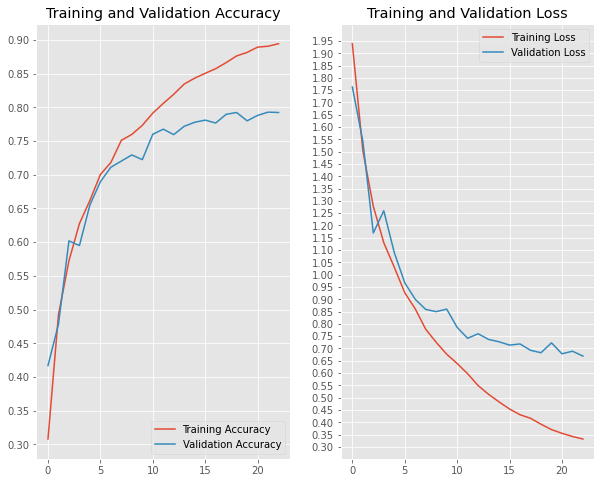

Time taken:  114.87601351737976


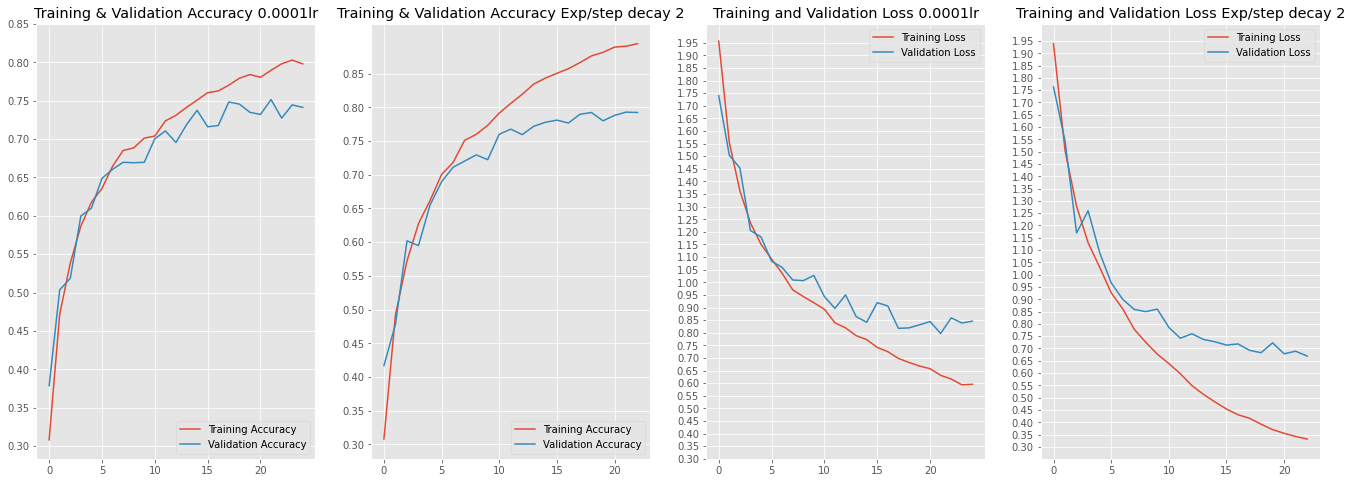

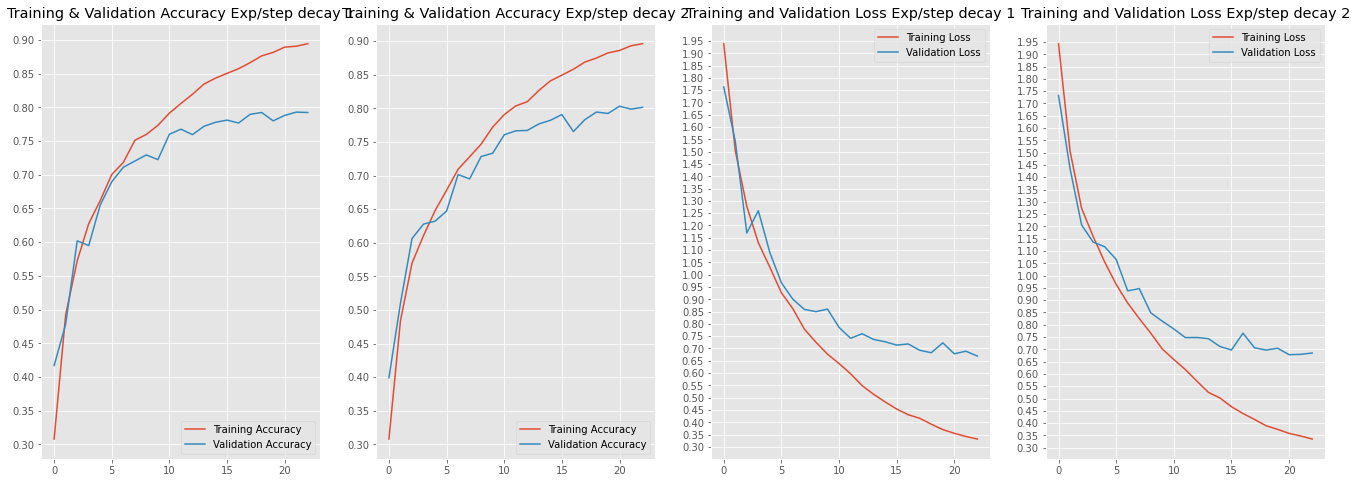

In [ ]:
model_performance(model_exp_step_fit)
model_performance_two(model_b_tanh_fit, '0.0001lr', model_exp_step_fit, 'Exp/step decay 2')
model_performance_two(model_exp_step_fit, 'Exp/step decay 1', model_exp_step2_fit, 'Exp/step decay 2')

As shown above, the best decay function (in terms of highest accuracy) that was the second function as follows: 
<br> Starting learning rate at 0.0028
<br> Epochs 1 to 5: no decay 
<br> Epochs 6 to 10: decay with exp(-0.1)
<br> Epochs 11 to 16: decay with exp(-0.15)
<br> Epochs 17 to end: decay with exp(-0.20)

# Final Model

Let us evaluate the final model that was used on the test dataset

In [ ]:
model_exp_step.evaluate(test_ds)      #test accuracy: ~79%

121/121 [==============================] - 1s 7ms/step - loss: 0.7034 - accuracy: 0.7941


[0.7034241557121277, 0.7940871119499207]

The final model architecture is also visualized (used in the report)

In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-o2vi2py3
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-o2vi2py3
  Resolved https://github.com/paulgavrikov/visualkeras to commit d7111d3471173c0b16853a6ce5e4cc645498380a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 13.1 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13448 sha256=5281d10bb5d5382a0adb4c89878fc7503eda6f84f238e8dcf68102d66db90b0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-k6lj3cmi/wheels/3a/96/3c/e6bcf58185d2017dc7b072e5794e6b1dd034d1bdb7d15e2463
Successfully built visualkeras


In [ ]:
import visualkeras

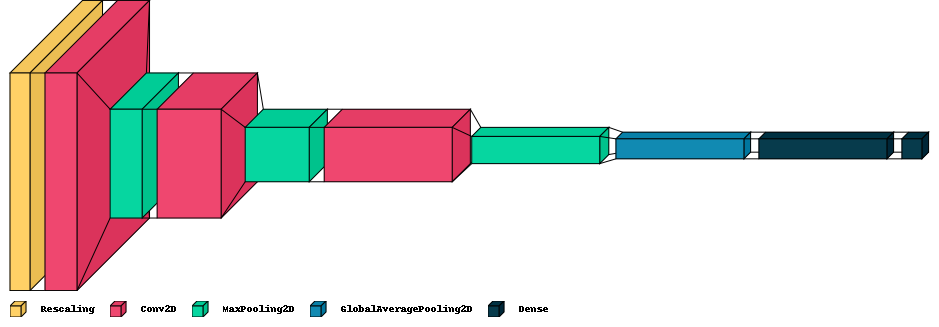

In [ ]:
visualkeras.layered_view(model_exp_step, spacing=15,scale_xy=1.7,scale_z=1, legend = True, to_file='drive/MyDrive/DSA4212/model_viz.png').show()

Note that the final model will incorporate the most useful methods found in the notebook which include: 
<br> 1. VGG-inspired architecture 
<br> 2. Global Average Pooling 
<br> 3. He Uniform Initializer 
<br> 4. ReLU + tanh Activation functions 
<br> 5. Custom Learning Rate decay (with ADAM, Exponential and step)

This will be used in the final model with other methods found useful from other experiments as well. 

